This notebook is used to run runtime or accuracy comparison experiments.

In [2]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()

import itertools
import random
import operator

import glob

import os, sys
sys.path.append(os.path.join("../"))

# Configure logging
import logging
logging.basicConfig(
    filename='experiments.log',  # Name of the log file
    level=logging.DEBUG,  # Set the logging level
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'  # Log message format
)

# our library
from src.mcmc_sat import models, mcmc, smt


## Triangle

In [2]:
num_samples = np.arange(100, 25001, step=5000)

In [3]:
# Timeout
TIMEOUT = 60*5 # seconds (5min)


(g, num_bits, num_vars) = models.get_triangle_sat()
(s, num_vars) = models.get_triangle_smt()
backends = ['spur', 'cmsgen', 'megasampler']
traces_triangle = [
    (samples,
        [[mcmc.sample_mh_trace_from_z3_model(
            backend=backend,
            z3_problem=g,
            num_bits=num_bits,
            num_vars=num_vars,
            timeout_sampler=TIMEOUT,
            num_samples=samples) 
        if backend in ['spur','cmsgen']
        else mcmc.sample_mh_trace_from_z3_model(
                backend=backend,
                z3_problem=s,
                algo='MeGAb', #  MeGA not working
                timeout_sampler=TIMEOUT,
                reweight_samples=True,
                num_samples=samples)
        for rep in range(3)] for backend in backends ]) # we run each experiment 3 times
    for samples in num_samples]

Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	47/47/0
independent support size:  	0
clauses (all/long/binary/unit): 151/75/69/7
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	2466 MB

STAGE #1: Build the initial partial assignments
STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	2466 MB

Sample #1 of 4 is already a complete assignment.  Continuing...
Completing sample #2 of 4 which has 4 variables unset and 11 samples.
Completing sample #3 of 4 which has 11 variables unset and 22 samples.
Completing sample #4 of 4 which has 8 variables unset and 18 samples.
STAGE #2 - COMPLETE


variables (total / active / free)	47

megasampler(__cxa_throw+0x9d)[0x6122db243fa1]
megasampler(+0x15a69)[0x6122db244a69]
megasampler(_ZN7Sampler11start_epochEv+0x1b5)[0x6122db24d925]
megasampler(_ZN4MeGA11regular_runERN2z37contextERKNS_4argsE+0x2eb)[0x6122db270e9b]
megasampler(main+0x175)[0x6122db245095]
/lib/x86_64-linux-gnu/libc.so.6(+0x2a1ca)[0x70e2e242a1ca]
/lib/x86_64-linux-gnu/libc.so.6(__libc_start_main+0x8b)[0x70e2e242a28b]
megasampler(_start+0x25)[0x6122db245145]
megasampler(__cxa_throw+0x9d)[0x5f3ea7f03fa1]
megasampler(+0x15a69)[0x5f3ea7f04a69]
megasampler(_ZN7Sampler11start_epochEv+0x1b5)[0x5f3ea7f0d925]
megasampler(_ZN4MeGA11regular_runERN2z37contextERKNS_4argsE+0x2eb)[0x5f3ea7f30e9b]
megasampler(main+0x175)[0x5f3ea7f05095]
/lib/x86_64-linux-gnu/libc.so.6(+0x2a1ca)[0x7d16e542a1ca]
/lib/x86_64-linux-gnu/libc.so.6(__libc_start_main+0x8b)[0x7d16e542a28b]
megasampler(_start+0x25)[0x5f3ea7f05145]
megasampler(__cxa_throw+0x9d)[0x643a4d370fa1]
megasampler(+0x15a69)[0x643a4d371a69]
megasampler(_ZN7Sampler11start_epoch

Parsing input file: megasampler_input/z3_problem.smt2
Number of formulas in file: 7
-------------FORMULA STATISTICS-------------
Arrays 0
Bit-vectors 0
Bools 0
Bits 0
Uninterpreted functions 0
Ints 3
Reals 0
Formula tree depth 2
--------------------------------------------
starting MeGASampler
Formula is satisfiable
Termination due to: index out of bounds
---------SOLVING STATISTICS--------
do_epoch time: 0.00112763
epoch time: 0.020129
grow_seed time: 0.000833105
initial_solving time: 0.000952925
output time: 2.0526e-05
start_epoch time: 0.0189843
total time: 0.0220415
Epochs: 16
MAX-SMT calls: 1
SMT calls: 17
Assignments considered (with repetitions): 16
Models (with repetitions): 16
Unique models (# samples in file): 16
-----------------------------------
Samples have been reweighted. The sampler generated 16 and the reweighting process has generated 96 (according to the unnormalized posterior probability specified in the input parameter `f`).

Parsing input file: megasampler_input/

megasampler(__cxa_throw+0x9d)[0x5fa6147b9fa1]
megasampler(+0x15a69)[0x5fa6147baa69]
megasampler(_ZN7Sampler11start_epochEv+0x1b5)[0x5fa6147c3925]
megasampler(_ZN4MeGA11regular_runERN2z37contextERKNS_4argsE+0x2eb)[0x5fa6147e6e9b]
megasampler(main+0x175)[0x5fa6147bb095]
/lib/x86_64-linux-gnu/libc.so.6(+0x2a1ca)[0x7c10aa62a1ca]
/lib/x86_64-linux-gnu/libc.so.6(__libc_start_main+0x8b)[0x7c10aa62a28b]
megasampler(_start+0x25)[0x5fa6147bb145]
megasampler(__cxa_throw+0x9d)[0x60cc48292fa1]
megasampler(+0x15a69)[0x60cc48293a69]
megasampler(_ZN7Sampler11start_epochEv+0x1b5)[0x60cc4829c925]
megasampler(_ZN4MeGA11regular_runERN2z37contextERKNS_4argsE+0x2eb)[0x60cc482bfe9b]
megasampler(main+0x175)[0x60cc48294095]
/lib/x86_64-linux-gnu/libc.so.6(+0x2a1ca)[0x77ecbfc2a1ca]
/lib/x86_64-linux-gnu/libc.so.6(__libc_start_main+0x8b)[0x77ecbfc2a28b]
megasampler(_start+0x25)[0x60cc48294145]
megasampler(__cxa_throw+0x9d)[0x5c7f75205fa1]
megasampler(+0x15a69)[0x5c7f75206a69]
megasampler(_ZN7Sampler11start_epoch

Formula is satisfiable
Termination due to: index out of bounds
---------SOLVING STATISTICS--------
do_epoch time: 0.0263445
epoch time: 0.0466268
grow_seed time: 0.000864772
initial_solving time: 0.00172969
output time: 0.000151182
start_epoch time: 0.0202656
total time: 0.0494301
Epochs: 16
MAX-SMT calls: 1
SMT calls: 17
Assignments considered (with repetitions): 1632
Models (with repetitions): 1632
Unique models (# samples in file): 16
-----------------------------------
Samples have been reweighted. The sampler generated 16 and the reweighting process has generated 5088 (according to the unnormalized posterior probability specified in the input parameter `f`).

Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	47/47/0
independent support size:  	0
clauses (all/long/binary/unit): 151/75/69/7
Initialize

megasampler(__cxa_throw+0x9d)[0x61efb93a2fa1]
megasampler(+0x15a69)[0x61efb93a3a69]
megasampler(_ZN7Sampler11start_epochEv+0x1b5)[0x61efb93ac925]
megasampler(_ZN4MeGA11regular_runERN2z37contextERKNS_4argsE+0x2eb)[0x61efb93cfe9b]
megasampler(main+0x175)[0x61efb93a4095]
/lib/x86_64-linux-gnu/libc.so.6(+0x2a1ca)[0x765b99a2a1ca]
/lib/x86_64-linux-gnu/libc.so.6(__libc_start_main+0x8b)[0x765b99a2a28b]
megasampler(_start+0x25)[0x61efb93a4145]
megasampler(__cxa_throw+0x9d)[0x5872df02dfa1]
megasampler(+0x15a69)[0x5872df02ea69]
megasampler(_ZN7Sampler11start_epochEv+0x1b5)[0x5872df037925]
megasampler(_ZN4MeGA11regular_runERN2z37contextERKNS_4argsE+0x2eb)[0x5872df05ae9b]
megasampler(main+0x175)[0x5872df02f095]
/lib/x86_64-linux-gnu/libc.so.6(+0x2a1ca)[0x76bfdb02a1ca]
/lib/x86_64-linux-gnu/libc.so.6(__libc_start_main+0x8b)[0x76bfdb02a28b]
megasampler(_start+0x25)[0x5872df02f145]


Parsing input file: megasampler_input/z3_problem.smt2
Number of formulas in file: 7
-------------FORMULA STATISTICS-------------
Arrays 0
Bit-vectors 0
Bools 0
Bits 0
Uninterpreted functions 0
Ints 3
Reals 0
Formula tree depth 2
--------------------------------------------
starting MeGASampler
Formula is satisfiable
Termination due to: index out of bounds
---------SOLVING STATISTICS--------
do_epoch time: 0.0264291
epoch time: 0.0455612
grow_seed time: 0.000883591
initial_solving time: 0.00126346
output time: 0.000153917
start_epoch time: 0.0191154
total time: 0.0478809
Epochs: 16
MAX-SMT calls: 1
SMT calls: 17
Assignments considered (with repetitions): 1632
Models (with repetitions): 1632
Unique models (# samples in file): 16
-----------------------------------
Samples have been reweighted. The sampler generated 16 and the reweighting process has generated 10096 (according to the unnormalized posterior probability specified in the input parameter `f`).

Using default filename: "spur_i

megasampler(__cxa_throw+0x9d)[0x5b0046b91fa1]
megasampler(+0x15a69)[0x5b0046b92a69]
megasampler(_ZN7Sampler11start_epochEv+0x1b5)[0x5b0046b9b925]
megasampler(_ZN4MeGA11regular_runERN2z37contextERKNS_4argsE+0x2eb)[0x5b0046bbee9b]
megasampler(main+0x175)[0x5b0046b93095]
/lib/x86_64-linux-gnu/libc.so.6(+0x2a1ca)[0x70c11722a1ca]
/lib/x86_64-linux-gnu/libc.so.6(__libc_start_main+0x8b)[0x70c11722a28b]
megasampler(_start+0x25)[0x5b0046b93145]


Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	47/47/0
independent support size:  	0
clauses (all/long/binary/unit): 151/75/69/7
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	2413 MB

STAGE #1: Build the initial partial assignments
STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	2413 MB

Sample #1 of 4 is already a complete assignment.  Continuing...
Completing sample #2 of 4 which has 4 variables unset and 1946 samples.
Completing sample #3 of 4 which has 11 variables unset and 2815 samples.
Completing sample #4 of 4 which has 8 variables unset and 2757 samples.
STAGE #2 - COMPLETE


variables (total / active / fr

megasampler(__cxa_throw+0x9d)[0x600c41addfa1]
megasampler(+0x15a69)[0x600c41adea69]
megasampler(_ZN7Sampler11start_epochEv+0x1b5)[0x600c41ae7925]
megasampler(_ZN4MeGA11regular_runERN2z37contextERKNS_4argsE+0x2eb)[0x600c41b0ae9b]
megasampler(main+0x175)[0x600c41adf095]
/lib/x86_64-linux-gnu/libc.so.6(+0x2a1ca)[0x7f24fba2a1ca]
/lib/x86_64-linux-gnu/libc.so.6(__libc_start_main+0x8b)[0x7f24fba2a28b]
megasampler(_start+0x25)[0x600c41adf145]
megasampler(__cxa_throw+0x9d)[0x6355b7861fa1]
megasampler(+0x15a69)[0x6355b7862a69]
megasampler(_ZN7Sampler11start_epochEv+0x1b5)[0x6355b786b925]
megasampler(_ZN4MeGA11regular_runERN2z37contextERKNS_4argsE+0x2eb)[0x6355b788ee9b]
megasampler(main+0x175)[0x6355b7863095]
/lib/x86_64-linux-gnu/libc.so.6(+0x2a1ca)[0x71c7e7e2a1ca]
/lib/x86_64-linux-gnu/libc.so.6(__libc_start_main+0x8b)[0x71c7e7e2a28b]
megasampler(_start+0x25)[0x6355b7863145]


Samples have been reweighted. The sampler generated 16 and the reweighting process has generated 15088 (according to the unnormalized posterior probability specified in the input parameter `f`).

Parsing input file: megasampler_input/z3_problem.smt2
Number of formulas in file: 7
-------------FORMULA STATISTICS-------------
Arrays 0
Bit-vectors 0
Bools 0
Bits 0
Uninterpreted functions 0
Ints 3
Reals 0
Formula tree depth 2
--------------------------------------------
starting MeGASampler
Formula is satisfiable
Termination due to: index out of bounds
---------SOLVING STATISTICS--------
do_epoch time: 0.0265605
epoch time: 0.0457032
grow_seed time: 0.000863471
initial_solving time: 0.00101304
output time: 0.000149809
start_epoch time: 0.0191271
total time: 0.0477964
Epochs: 16
MAX-SMT calls: 1
SMT calls: 17
Assignments considered (with repetitions): 1632
Models (with repetitions): 1632
Unique models (# samples in file): 16
-----------------------------------
Samples have been reweighted. T

megasampler(__cxa_throw+0x9d)[0x5c56e3934fa1]
megasampler(+0x15a69)[0x5c56e3935a69]
megasampler(_ZN7Sampler11start_epochEv+0x1b5)[0x5c56e393e925]
megasampler(_ZN4MeGA11regular_runERN2z37contextERKNS_4argsE+0x2eb)[0x5c56e3961e9b]
megasampler(main+0x175)[0x5c56e3936095]
/lib/x86_64-linux-gnu/libc.so.6(+0x2a1ca)[0x7c08a242a1ca]
/lib/x86_64-linux-gnu/libc.so.6(__libc_start_main+0x8b)[0x7c08a242a28b]
megasampler(_start+0x25)[0x5c56e3936145]


Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	48/48/0
independent support size:  	0
clauses (all/long/binary/unit): 154/76/71/7
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	2440 MB

STAGE #1: Build the initial partial assignments
STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	2440 MB

Sample #1 of 2 is already a complete assignment.  Continuing...
Completing sample #2 of 2 which has 9 variables unset and 2549 samples.
STAGE #2 - COMPLETE


variables (total / active / free)	48/48/0
clauses (removed) 		154 (0)
decisions 				14
conflicts 				0
conflict clauses (all/bin/unit) 	3/2/7
failed literals found by implicit

megasampler(__cxa_throw+0x9d)[0x55625ead3fa1]
megasampler(+0x15a69)[0x55625ead4a69]
megasampler(_ZN7Sampler11start_epochEv+0x1b5)[0x55625eadd925]
megasampler(_ZN4MeGA11regular_runERN2z37contextERKNS_4argsE+0x2eb)[0x55625eb00e9b]
megasampler(main+0x175)[0x55625ead5095]
/lib/x86_64-linux-gnu/libc.so.6(+0x2a1ca)[0x76ecece2a1ca]
/lib/x86_64-linux-gnu/libc.so.6(__libc_start_main+0x8b)[0x76ecece2a28b]
megasampler(_start+0x25)[0x55625ead5145]
megasampler(__cxa_throw+0x9d)[0x6428be0c9fa1]
megasampler(+0x15a69)[0x6428be0caa69]
megasampler(_ZN7Sampler11start_epochEv+0x1b5)[0x6428be0d3925]
megasampler(_ZN4MeGA11regular_runERN2z37contextERKNS_4argsE+0x2eb)[0x6428be0f6e9b]
megasampler(main+0x175)[0x6428be0cb095]
/lib/x86_64-linux-gnu/libc.so.6(+0x2a1ca)[0x7ef9d2c2a1ca]
/lib/x86_64-linux-gnu/libc.so.6(__libc_start_main+0x8b)[0x7ef9d2c2a28b]
megasampler(_start+0x25)[0x6428be0cb145]
megasampler(__cxa_throw+0x9d)[0x5760f27e2fa1]
megasampler(+0x15a69)[0x5760f27e3a69]
megasampler(_ZN7Sampler11start_epoch

Formula is satisfiable
Termination due to: index out of bounds
---------SOLVING STATISTICS--------
do_epoch time: 0.0450813
epoch time: 0.0805883
grow_seed time: 0.00167161
initial_solving time: 0.00168491
output time: 0.00028665
start_epoch time: 0.0354857
total time: 0.0833186
Epochs: 16
MAX-SMT calls: 1
SMT calls: 17
Assignments considered (with repetitions): 1632
Models (with repetitions): 1632
Unique models (# samples in file): 16
-----------------------------------
Samples have been reweighted. The sampler generated 16 and the reweighting process has generated 20096 (according to the unnormalized posterior probability specified in the input parameter `f`).

Parsing input file: megasampler_input/z3_problem.smt2
Number of formulas in file: 7
-------------FORMULA STATISTICS-------------
Arrays 0
Bit-vectors 0
Bools 0
Bits 0
Uninterpreted functions 0
Ints 3
Reals 0
Formula tree depth 2
--------------------------------------------
starting MeGASampler
Formula is satisfiable
Terminatio

In [4]:
# Analytical solution
p_x0 = lambda x: 1/4
p_x1 = lambda x: 1/4
p_x0x1 = lambda x: sum([p_x0(i)*p_x1(j) if i+j == x else 0 for i in range(4) for j in range(4)])

### Mean convergence experiments (absolute distance)

In [5]:
def p_est(trace, var_name, outcome):
    return np.mean(trace[var_name] == outcome)
data_triangle = {
    'samples':  [],
    'backend':  [],
    'var_name': [],
    'err_mean_mean': [],
    'err_mean_var': []
}
for (samples, traces) in traces_triangle:
    for (backend, trace_reps) in zip(backends, traces):
        for (f, var_name) in zip([p_x0, p_x1, p_x0x1],['x0','x1','x2']):
            outcomes = range(4) if var_name != 'x2' else range(6)
            err_outcome_means = [np.mean([np.abs(p_est(trace.posterior.sel(chain=0),var_name, o).item() - f(o)) for o in outcomes]) for trace in trace_reps]
            data_triangle['samples'].append(samples)
            data_triangle['backend'].append(backend)
            data_triangle['var_name'].append(var_name)
            data_triangle['err_mean_mean'].append(np.mean(err_outcome_means))
            data_triangle['err_mean_var'].append(np.var(err_outcome_means))
df_triangle = pd.DataFrame(data_triangle)

In [6]:
df_triangle[(df_triangle.samples == 5100) & (df_triangle.backend == 'spur')]

,samples,backend,var_name,err_mean_mean,err_mean_var
9,5100,spur,x0,0.003758,0.000001
10,5100,spur,x1,0.007288,0.000006
11,5100,spur,x2,0.004436,0.000002


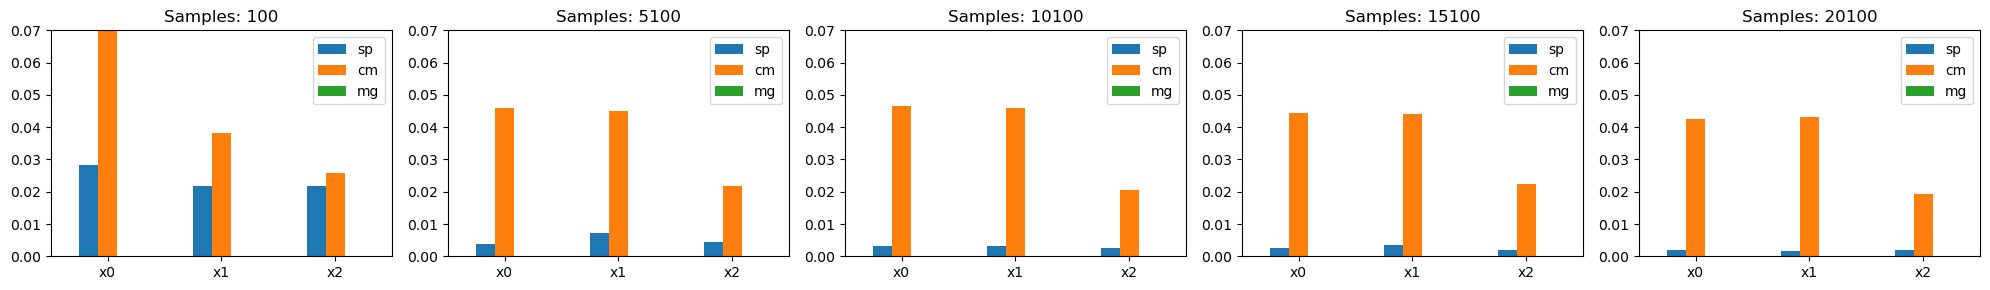

In [7]:
fig, axs = plt.subplots(1,len(num_samples),figsize=(20,3))
for (s,a) in zip(num_samples, axs):
    data = {b: [] for b in backends}
    for b in backends:
        data[b] = df_triangle[(df_triangle.samples == s) & (df_triangle.backend == b)].err_mean_mean.values
    df_temp = pd.DataFrame(data)
    ax = df_temp.plot.bar(ax=a)
    variables = df_triangle.var_name.unique()
    ax.set_xticks(range(len(variables)), variables,rotation=0)
    ax.set_ylim((0,0.07))
    ax.legend(['sp','cm','mg'])
    ax.set_title(f'Samples: {s}');

In [8]:
df_triangle[(df_triangle.var_name == 'x0') & (df_triangle.backend == 'spur')]

,samples,backend,var_name,err_mean_mean,err_mean_var
0,100,spur,x0,0.028333,3.722222e-04
9,5100,spur,x0,0.003758,1.443889e-06
18,10100,spur,x0,0.003267,1.359344e-06
27,15100,spur,x0,0.002627,1.381031e-06
36,20100,spur,x0,0.002081,2.579694e-07


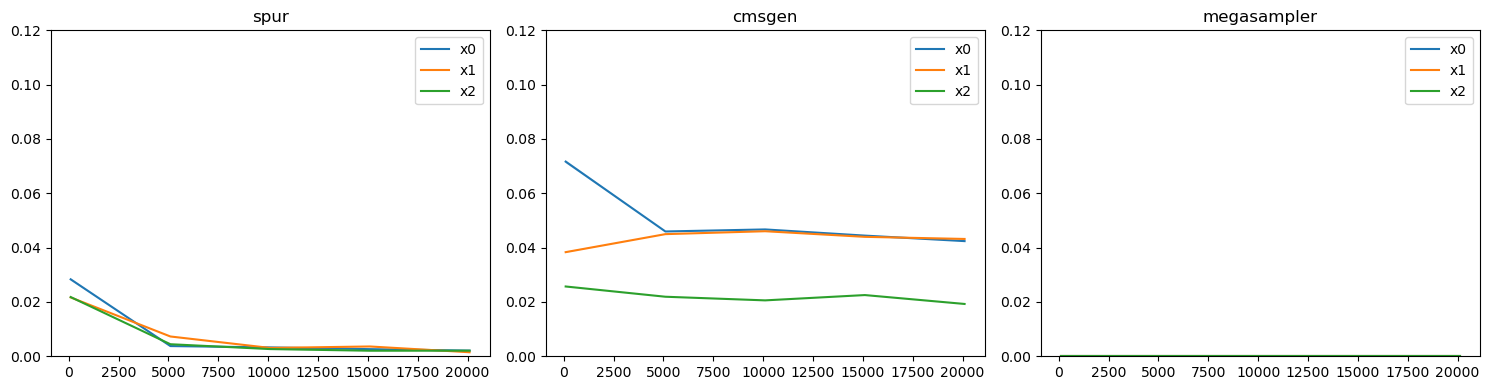

In [9]:
fig, axs = plt.subplots(1,len(backends),figsize=(15,4))

for (ax, b) in zip(axs, backends):
    ys = [(vn, 
           df_triangle[(df_triangle.var_name == vn) & (df_triangle.backend == b)].err_mean_mean.values,
           df_triangle[(df_triangle.var_name == vn) & (df_triangle.backend == b)].err_mean_var.values) for vn in ['x0','x1','x2']]
    for (vn, y, y_var) in ys:
        ax.plot(num_samples, y, label=vn)
        ax.fill_between(num_samples, y-y_var, y+y_var, alpha=0.2)
    ax.set_ylim((0,0.12))
    ax.set_title(f'{b}')
    ax.legend();

## DB CACM

In [10]:
num_samples = np.arange(100, 20000, step=5000)
TIMEOUT = 60*10 # seconds (10min)

(g, num_bits, num_vars) = models.get_db_cacm_sat()
(s, num_vars) = models.get_db_cacm_smt()
backends = ['spur', 'cmsgen', 'megasampler']
traces_db_cacm = [ 
        (samples, 
    [[mcmc.sample_mh_trace_from_z3_model(backend=backend,
                                       z3_problem=g,
                                       num_bits=num_bits,
                                       num_vars=num_vars,
                                       timeout_sampler=TIMEOUT,
                                       num_samples=samples)
    if backend in ['spur','cmsgen']
    else mcmc.sample_mh_trace_from_z3_model(
            backend=backend,
            z3_problem=s,
            timeout_sampler=TIMEOUT,
            reweight_samples=True,
            num_samples=samples)
    for rep in range(3)] for backend in backends ]) # we run each experiment 3 times
    for samples in num_samples]

Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	1602/1602/0
independent support size:  	0
clauses (all/long/binary/unit): 7498/5945/1494/59
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	2408 MB

STAGE #1: Build the initial partial assignments
STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	2408 MB

Sample #1 of 31 is already a complete assignment.  Continuing...
Completing sample #2 of 31 which has 30 variables unset and 1 sample.
Completing sample #3 of 31 which has 42 variables unset and 1 sample.
Completing sample #4 of 31 which has 52 variables unset and 1 sample.
Completing sample #5 of 31 which has 75 variable

### Mean convergence experiments (absolute distance)

In [11]:
## Analytical (brute force) solution to db_cacm

### list all ages with required median and average age
avg_sat = [ (x0,x1,30,x3,x4) 
            for x0 in range(31) 
            for x1 in range(31) 
            for x3 in range(30,126) 
            for x4 in range(30,126) 
            if x0+x1+30+x3+x4 == 38*5 and
               x0 <= x1 <= 30 <= x3 <= x4]

### list all genders with exactly 3 males
g_sat = [ (g0,g1,g2,g3,g4) 
          for g0 in range(2) 
          for g1 in range(2) 
          for g2 in range(2) 
          for g3 in range(2) 
          for g4 in range(2) 
          if g0+g1+g2+g3+g4 == 3]

### keep only entries with the required average for males
sat_models = [((x0,x1,x2,x3,x4), (g0,g1,g2,g3,g4))
              for (x0,x1,x2,x3,x4) in avg_sat 
              for (g0,g1,g2,g3,g4) in g_sat 
              if x0*g0 + x1*g1 + x2*g2 + x3*g3 + x4*g4 == 44*3
]

### prior on each variable type
p_x01 = lambda x: 1/31
p_x2 = lambda x: 1
p_x34 = lambda x: 1/96
p_g = lambda x: 1/2

### compute unnormalized posterior probabilities
### all variables are independent therefore it is the product
unnormalized_probs = np.array([p_x01(x0) * p_x01(x1) * p_x2(x2) * p_x34(x3) * p_x34(x4) * p_g(g0) * p_g(g1) * p_g(g2) * p_g(g3) * p_g(g4)
                               for (x0,x1,x2,x3,x4) in avg_sat 
                               for (g0,g1,g2,g3,g4) in g_sat 
                               if x0*g0 + x1*g1 + x2*g2 + x3*g3 + x4*g4 == 44*3
])

### compute total probability mass (normalizing factor)
total_prob = sum(unnormalized_probs)

### normalized probabilities
normalized_probs = unnormalized_probs/total_prob

### We put everything in a dataframe to easily make queries
d = {
    'x0': [], 'x1': [], 'x2': [], 'x3': [], 'x4': [], 
    'g0': [], 'g1': [], 'g2': [], 'g3': [], 'g4': [], 
    'p' : []
}

for (((x0,x1,x2,x3,x4), (g0,g1,g2,g3,g4)), p) in zip(sat_models,normalized_probs):
    d['x0'].append(x0)
    d['x1'].append(x1)
    d['x2'].append(x2)
    d['x3'].append(x3)
    d['x4'].append(x4)
    d['g0'].append(g0)
    d['g1'].append(g1)
    d['g2'].append(g2)
    d['g3'].append(g3)
    d['g4'].append(g4)
    d['p'].append(p)

df = pd.DataFrame(d)

### function to query exact solution probability for each variable and outcome
p_var = lambda x,i: df[df[x] == i].p.sum()

In [12]:
def p_est(trace, var_name, outcome):
    return np.mean(trace[var_name] == outcome)
data_db_cacm = {
    'samples':  [],
    'backend':  [],
    'var_name': [],
    'err_mean_mean': [],
    'err_mean_var': []
}
for (samples, traces) in traces_db_cacm:
    for (backend, trace_reps) in zip(backends, traces):
        for x in ['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9']:
            ## ranges are variable specific for DB cacm
            ran = range(30,31)
            if x in ['x0','x1']:
                ran = range(31)
            elif x in ['x3','x4']:
                ran = range(30,126)
            elif x in ['x5','x6','x7','x8','x9']:
                ran = range(2)                

            x_conv = x if x in ['x0','x1','x2','x3','x4'] else 'g'+str((int(x[1])-5))

            err_outcome_means = [np.mean([np.abs(p_est(trace.posterior.sel(chain=0),x, o).item() - p_var(x_conv,o)) for o in outcomes]) for trace in trace_reps]
            data_db_cacm['samples'].append(samples)
            data_db_cacm['backend'].append(backend)
            data_db_cacm['var_name'].append(x)
            data_db_cacm['err_mean_mean'].append(np.mean(err_outcome_means))
            data_db_cacm['err_mean_var'].append(np.var(err_outcome_means))
df_db_cacm = pd.DataFrame(data_db_cacm)

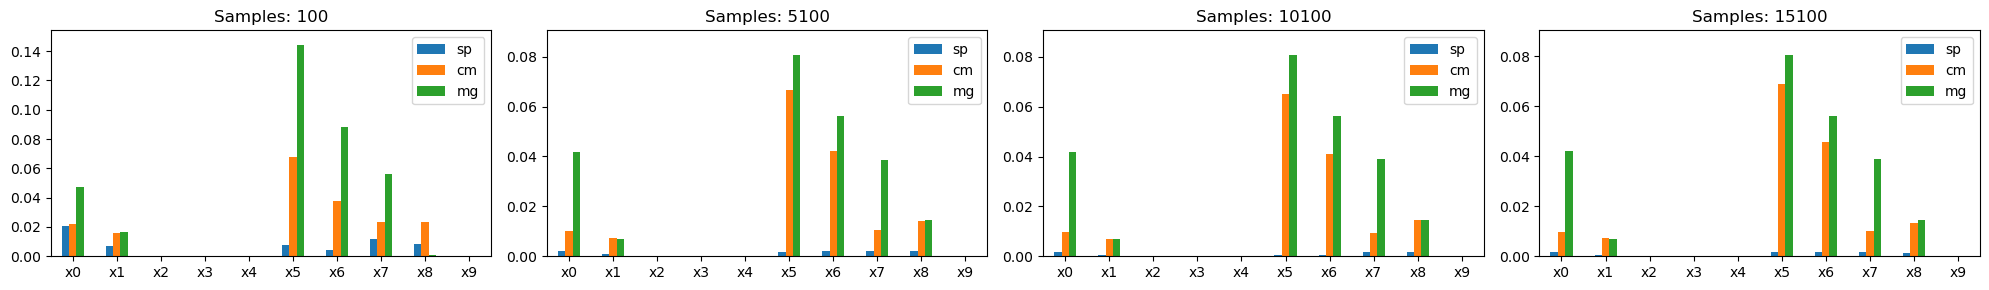

In [13]:
fig, axs = plt.subplots(1,len(num_samples),figsize=(20,3))
for (s,a) in zip(num_samples, axs):
    data = {b: [] for b in backends}
    for b in backends:
        data[b] = df_db_cacm[(df_db_cacm.samples == s) & (df_db_cacm.backend == b)].err_mean_mean.values
    df_temp = pd.DataFrame(data)
    ax = df_temp.plot.bar(ax=a)
    variables = df_db_cacm.var_name.unique()
    ax.set_xticks(range(len(variables)), variables,rotation=0)
    ax.set_ylim((0,np.max(df_temp.values+0.01)))
    ax.legend(['sp','cm','mg'])
    ax.set_title(f'Samples: {s}');

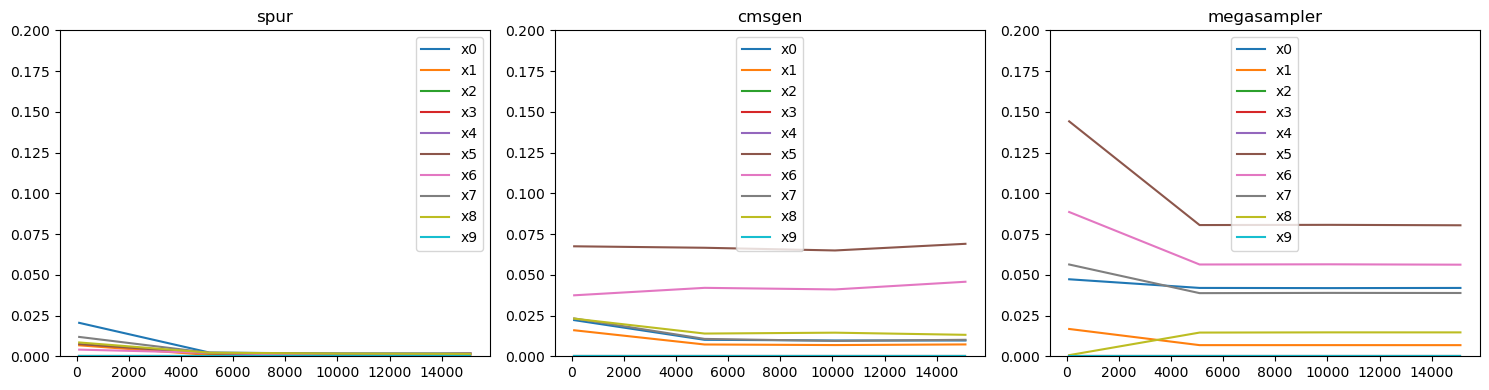

In [14]:
fig, axs = plt.subplots(1,len(backends),figsize=(15,4))

for (ax, b) in zip(axs, backends):
    ys = [(vn, 
           df_db_cacm[(df_db_cacm.var_name == vn) & (df_db_cacm.backend == b)].err_mean_mean.values,
           df_db_cacm[(df_db_cacm.var_name == vn) & (df_db_cacm.backend == b)].err_mean_var.values) 
              for vn in ['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9']]
    for (vn, y, y_var) in ys:
        ax.plot(num_samples, y, label=vn)
        ax.fill_between(num_samples, y-y_var, y+y_var, alpha=0.2)
    ax.set_ylim((0,0.2))
    ax.set_title(f'{b}')
    ax.legend();

## NZ Stats

In [15]:
num_samples = np.arange(100, 20000, step=5000)
TIMEOUT = 60*10 # seconds (10min)

(g, num_bits, num_vars) = models.get_nz_stats_sat(
    path_to_dataset='sat/spur/nz_db/south_head.csv'
)
(s, num_vars) = models.get_nz_stats_smt(
    path_to_dataset='sat/spur/nz_db/south_head.csv'
)
backends = ['spur', 'cmsgen', 'megasampler']
traces_nz_stats = [
    (samples,
    [[mcmc.sample_mh_trace_from_z3_model(backend=backend,
                                       z3_problem=g,
                                       num_bits=num_bits,
                                       num_vars=num_vars,
                                       timeout_sampler=TIMEOUT,
                                       num_samples=samples)
    if backend in ['spur','cmsgen']
    else mcmc.sample_mh_trace_from_z3_model(
            backend=backend,
            z3_problem=s,
            timeout_sampler=TIMEOUT,
            reweight_samples=True,
            num_samples=samples)
    for rep in range(3)] for backend in backends])
    for samples in num_samples]

Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	661/661/0
independent support size:  	0
clauses (all/long/binary/unit): 2025/1183/754/88
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	1688 MB

STAGE #1: Build the initial partial assignments
STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	1688 MB

Completing sample #1 of 2 which has 3 variables unset and 14 samples.
Sample #2 of 2 is already a complete assignment.  Continuing...
STAGE #2 - COMPLETE


variables (total / active / free)	661/661/0
clauses (removed) 		2025 (0)
decisions 				188
conflicts 				1
conflict clauses (all/bin/unit) 	32/20/88
failed literals found

### Convergence analysis

In [16]:
path_to_dataset = 'sat/spur/nz_db/south_head.csv'
south_head = pd.read_csv(path_to_dataset)
numpy_data = south_head.to_numpy()[:, 1:]

In [17]:
numpy_data

array([[3, 6, 6, 12, 9, 3, 9, 9, 6, 6, 15, 6, 3, 6, 3, 3, 0, 0, 0],
       [6, 0, 3, 6, 3, 6, 3, 9, 3, 6, 9, 6, 9, 3, 3, 3, 0, 0, 0],
       [15, 3, 12, 15, 15, 12, 9, 18, 9, 12, 21, 12, 12, 12, 6, 0, 0, 0,
        0]], dtype=object)

In [18]:
def get_values(x):
    upper_bound = x+2
    lower_bound = x-2 if x > 0 else 0
    return list(range(lower_bound,upper_bound+1))

In [19]:
p = lambda x: 1/5 if x > 0 else 1/3

In [20]:
unnorm_probs = [ [(i,j,p(numpy_data[0,k])*p(numpy_data[1,k])) 
   for i in get_values(numpy_data[0,k]) 
   for j in get_values(numpy_data[1,k])
   if (numpy_data[2,k] - 2) <= (i+j) <= (numpy_data[2,k] + 2)]
  for k in range(19)]

In [21]:
norm_probs = [[(x,y,prob1/sum([prob2 for (_,_,prob2) in i])) for (x,y,prob1) in i] for i in unnorm_probs]

In [22]:
p_var_nz_stats = lambda var_num, outcome: sum([t[2] for t in norm_probs[var_num%19] if t[int(var_num > 18)] == outcome])
p_var = lambda x,o: p_var_nz_stats(x,o)

In [23]:
def p_est(trace, var_name, outcome):
    return np.mean(trace[var_name] == outcome)
data_nz_stats = {
    'samples':  [],
    'backend':  [],
    'var_name': [],
    'err_mean_mean': [],
    'err_mean_var': []
}
for (samples, traces) in traces_nz_stats:
    for (backend, trace_reps) in zip(backends, traces):
        for x in [f'x{i}' for i in range(19*2)]:
            ## ranges are variable specific for NZ DB
            var_int_id = int(x[1:])
            ran = get_values(numpy_data[int(var_int_id > 18),(var_int_id%19)])
            outcomes = ran

            err_outcome_means = [np.mean([np.abs(p_est(trace.posterior.sel(chain=0), x, o).item() - p_var(var_int_id,o)) for o in outcomes]) for trace in trace_reps]
            data_nz_stats['samples'].append(samples)
            data_nz_stats['backend'].append(backend)
            data_nz_stats['var_name'].append(x)
            data_nz_stats['err_mean_mean'].append(np.mean(err_outcome_means))
            data_nz_stats['err_mean_var'].append(np.var(err_outcome_means))
df_nz_stats = pd.DataFrame(data_nz_stats)

In [24]:
df_nz_stats

,samples,backend,var_name,err_mean_mean,err_mean_var
0,100,spur,x0,0.000000,0.000000e+00
1,100,spur,x1,0.018667,2.488889e-05
2,100,spur,x2,0.030667,6.755556e-05
3,100,spur,x3,0.024000,7.466667e-05
4,100,spur,x4,0.034667,1.102222e-04
...,...,...,...,...,...
451,15100,megasampler,x33,0.147368,2.567907e-34
452,15100,megasampler,x34,0.000000,0.000000e+00
453,15100,megasampler,x35,0.111111,1.925930e-34
454,15100,megasampler,x36,0.111685,6.588405e-07


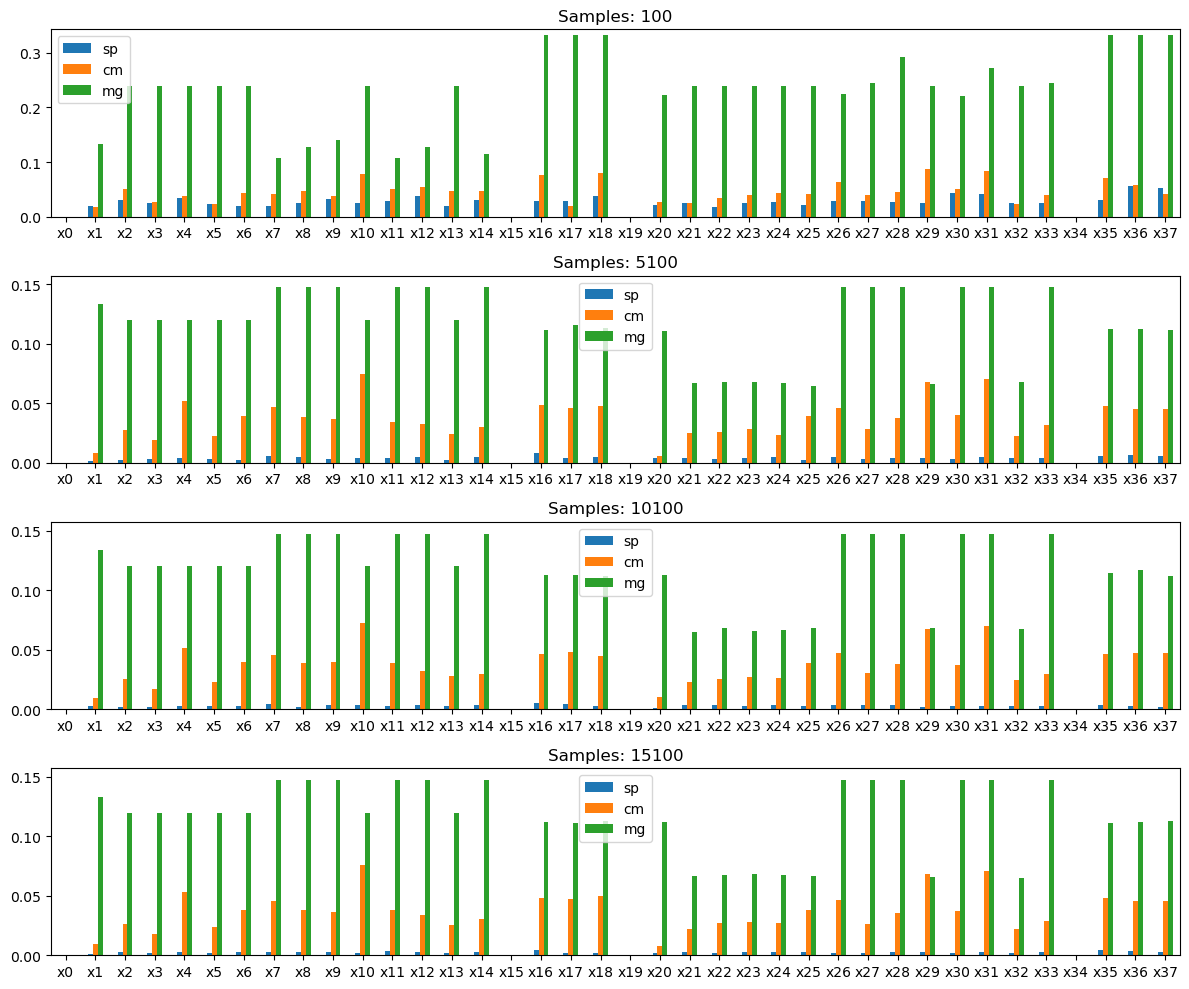

In [25]:
fig, axs = plt.subplots(len(num_samples),1,figsize=(12,10))
for (s,a) in zip(num_samples, axs):
    data = {b: [] for b in backends}
    for b in backends:
        data[b] = df_nz_stats[(df_nz_stats.samples == s) & (df_nz_stats.backend == b)].err_mean_mean.values
    df_temp = pd.DataFrame(data)
    ax = df_temp.plot.bar(ax=a)
    variables = df_nz_stats.var_name.unique()
    ax.set_xticks(range(len(variables)), variables,rotation=0)
    ax.set_ylim((0,np.max(df_temp.values+0.01)))
    ax.legend(['sp','cm','mg'])
    ax.set_title(f'Samples: {s}');

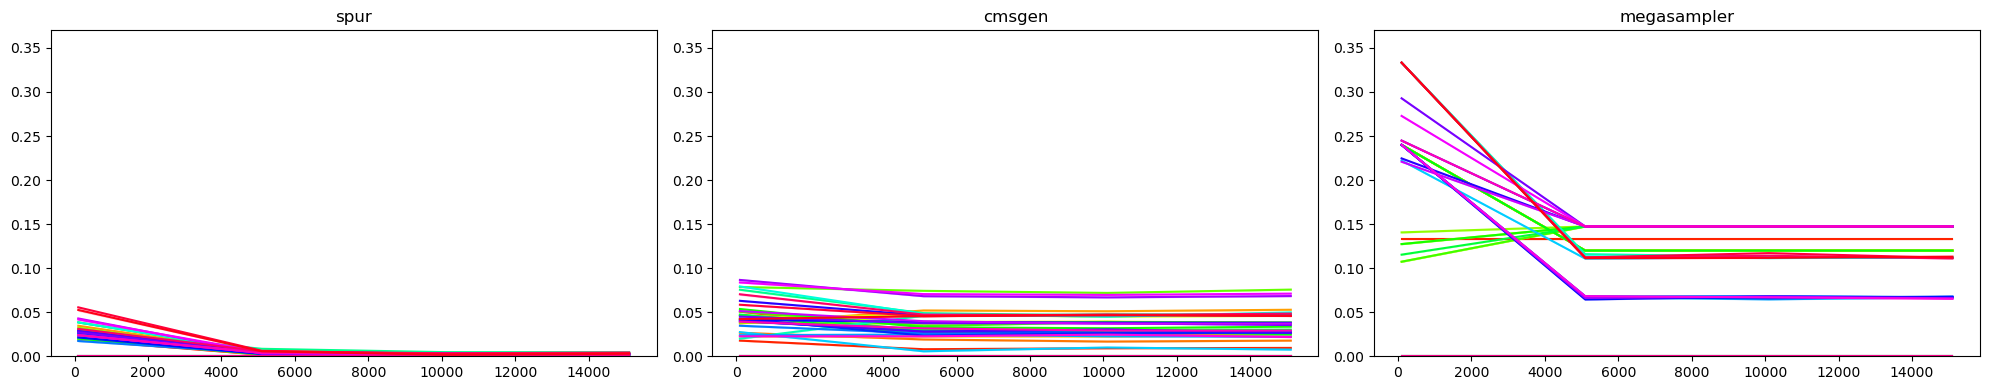

In [26]:
fig, axs = plt.subplots(1,len(backends),figsize=(20,4))

for (ax, b) in zip(axs, backends):
    ys = [(vn, 
           df_nz_stats[(df_nz_stats.var_name == vn) & (df_nz_stats.backend == b)].err_mean_mean.values,
           df_nz_stats[(df_nz_stats.var_name == vn) & (df_nz_stats.backend == b)].err_mean_var.values) 
              for vn in [f'x{i}' for i in range(19*2)]]
    for ((vn, y, y_var), c) in zip(ys,plt.cm.hsv(np.linspace(0, 1, len(ys)))):
        ax.plot(num_samples, y, color=c, label=vn)
        ax.fill_between(num_samples, y-y_var, y+y_var, color=c, alpha=0.2)
    ax.set_ylim((0,0.37))
    ax.set_title(f'{b}');
    # ax.legend(); # due to the large number of variables I set the legend off

## Roads

In [ ]:
y = np.array([1087, 1008, 1068, 1204, 1158, 1151, 1143])

## Parameters of the experiments
num_samples = [ 100,  500,  1000, 3000, 7000]
TIMEOUT = 60*10 # seconds (10min)

## Global variables for the cell used in the experiments
num_con = 7; reduction_factor = 4;

## Automatically calculated necessary bits
num_bits = int(np.log2((y[:num_con]/reduction_factor).max()))+1;
max_int_bits = max([int(np.log2((total/summands)+1))+1 
                    for (summands,total) in zip(models.__gen_conf_matrix(np.array([1,2,3,4,5,6,7][:num_con])).sum(axis=1), (y[:num_con]/reduction_factor))])
max_int_bv = 2**max_int_bits-1
 
## Get models
(g, num_bits, num_vars) = models.get_roads_sat(num_bits = num_bits,
                                               max_int_bv = max_int_bv,
                                               num_con=num_con,
                                               y_reduction_factor=reduction_factor)
(s, num_vars) = models.get_roads_smt(max_int = max_int_bv, 
                                     num_con=num_con,
                                     y_reduction_factor=reduction_factor)

# backends
backends = ['spur', 'cmsgen', 'megasampler']

# logger
logger = logging.getLogger(f"Roads runtime | con {num_con} | bits {num_bits} | max_int {max_int_bv}")

# timeouts
timeout = {
    'spur': False,
    'cmsgen': False,
    'megasampler': False
}
### Global variables for the cell used in the experiments

def executing_roads_with_backend(samples, backend):
    logger.info(f'Running roads with {backend} and generating {samples} samples')

    if timeout[backend]:
        return (600, 0, None)

    # catch TIMEOUT exception
    try:
        (time_sample_gen, time_mcmc, trace) = \
            mcmc.sample_mh_trace_from_z3_model(
                backend=backend,
                z3_problem=g,
                num_bits=num_bits,
                num_vars=num_vars,
                timeout_sampler=TIMEOUT,
                num_samples=samples,
                time_execution=True) \
        if backend in ['spur','cmsgen'] \
        else mcmc.sample_mh_trace_from_z3_model(
                backend=backend,
                z3_problem=s,
                reweight_samples=True,
                timeout_sampler=TIMEOUT,
                num_samples=samples,
                time_execution=True)
    except Exception as exception:
        logger.error(exception.__class__.__name__)
        (time_sample_gen, time_mcmc, trace) = (600, 0, None)
    
    timeout[backend] = (time_sample_gen + time_mcmc) >= 600

    logger.info(f'Execution finished in {time_sample_gen + time_mcmc} seconds')

    return (time_sample_gen, time_mcmc, trace)
    


traces_roads = [
    (samples,
    [[executing_roads_with_backend(samples, backend)
    for rep in range(3)] for backend in backends])
    for samples in num_samples]

[(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (4, 5), (4, 6), (4, 7), (4, 8), (5, 6), (5, 7), (5, 8), (6, 7), (6, 8), (7, 8)]
[(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (4, 5), (4, 6), (4, 7), (4, 8), (5, 6), (5, 7), (5, 8), (6, 7), (6, 8), (7, 8)]
[(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (4, 5), (4, 6), (4, 7), (4, 8), (5, 6), (5, 7), (5, 8), (6, 7), (6, 8), (7, 8)]
Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	4923/4923/0
independent support size:  	0
clauses (all/long/binary/unit): 25001/20913/3975

ERROR: TIMEOUT


c CMSGen Copyright Mate Soos (soos.mate@gmail.com)
c CMSGen SHA revision 422a9dbaba3f749c2df811d9dfab7ffd4627bac5
c CMSGen is MIT licensed
c CMSGen compilation env CMAKE_CXX_COMPILER = /usr/bin/c++ | CMAKE_CXX_FLAGS =  -mtune=native -Wall -Wextra -Wunused -Wsign-compare -fno-omit-frame-pointer -Wtype-limits -Wuninitialized -Wno-deprecated -Wstrict-aliasing -Wpointer-arith -Wpointer-arith -Wformat-nonliteral -Winit-self -Wparentheses -Wunreachable-code -ggdb3 -Wno-class-memaccess -Wlogical-op -Wrestrict -Wnull-dereference -Wdouble-promotion -Wshadow -Wformat=2 -Wextra-semi -pedantic | COMPILE_DEFINES =  -DUSE_GAUSS -DUSE_ZLIB -DYALSAT_FPU | STATICCOMPILE = OFF | ZLIB_FOUND = TRUE | VALGRIND_FOUND =  | ENABLE_TESTING =  | SLOW_DEBUG = OFF | ENABLE_ASSERTIONS = ON | MY_TARGETS =  | LARGEMEM =  | LIMITMEM =  | 
c CMSGen compiled with gcc version 13.2.0
c executed with command line: cmsgen --samples 100 --samplefile cmsgen_input/cmsgen_samples.out cmsgen_input/z3_problem.cnf
c Writing sampl

In [ ]:
data_roads = {
    'samples':  [],
    'backend':  [],
    'num_executions': [],
    'sampling_time_mean': [],
    'sampling_time_std': [],
    'metropolis_time_mean': [],
    'metropolis_time_std': [],
    'total_time_mean': [],
    'total_time_std': []
}
for (num_samples, results_per_backend) in traces_roads:
    for (backend, results) in zip(backends,results_per_backend):
        sampling_times = np.array([sampling_time for (sampling_time, _, _) in results])
        metropolis_times = np.array([metropolist_time for (_, metropolist_time, _) in results])
        total_times = sampling_times + metropolis_times
        data_roads['samples'].append(num_samples)
        data_roads['backend'].append(backend)
        data_roads['num_executions'].append(sampling_times.size)
        data_roads['sampling_time_mean'].append(sampling_times.mean())
        data_roads['sampling_time_std'].append(sampling_times.std())
        data_roads['metropolis_time_mean'].append(metropolis_times.mean())
        data_roads['metropolis_time_std'].append(metropolis_times.std())
        data_roads['total_time_mean'].append(total_times.mean())
        data_roads['total_time_std'].append(total_times.std())
df_roads = pd.DataFrame(data_roads)
df_roads.to_csv(f'roads_results_con_{num_con}_rf_{reduction_factor}_bits_{num_bits}_max_int_{max_int_bv}.csv')        

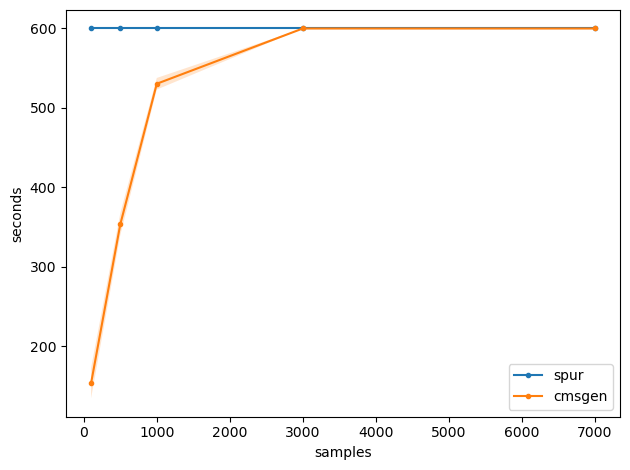

In [ ]:
fig, ax = plt.subplots(1)
x = df_roads.samples.unique()
for backend in backends:
    if backend not in ['megasampler']:
        means = df_roads[df_roads.backend == backend].total_time_mean
        stds  = df_roads[df_roads.backend == backend].total_time_std
        ax.plot(x, means, label=backend, marker='.')    
        ax.fill_between(x, means - stds, means + stds, alpha=0.2)
ax.set_ylabel('seconds')
ax.set_xlabel('samples')
plt.legend()
plt.show();

(0.0, 610.0)

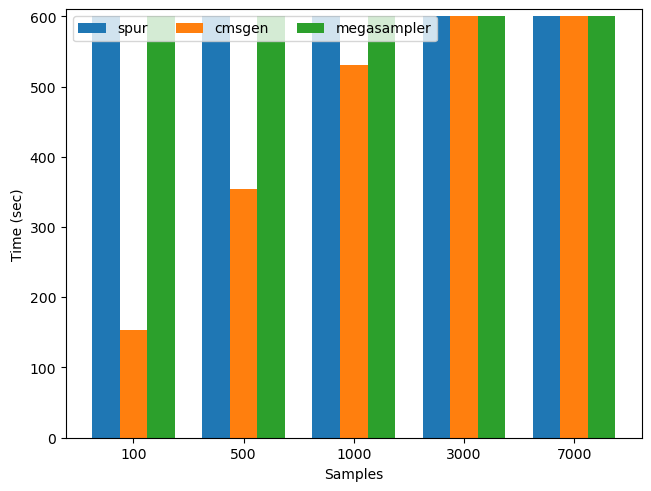

In [ ]:
num_samples_bars = df_roads.samples.unique()
means = {i: df_roads[df_roads.backend == i].total_time_mean for i in df_roads.backend.unique()}

x = np.arange(len(num_samples_bars))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

ax.set_ylabel('Time (sec)')
ax.set_xlabel('Samples')
ax.set_xticks(x + width, num_samples_bars)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 610)

### Some utility functions

In [91]:
def get_info_from_runtime_filename(filename: str):
    """
    Utility function to extract experiment information from filename format in roads and books runtime results files.
    """
    parsed_filename = filename.split('_')
    problem    = parsed_filename[0]
    num_con    = int(parsed_filename[3])
    red_fac    = int(parsed_filename[5])
    num_bits   = int(parsed_filename[7])
    max_int_bv = int(parsed_filename[10].split('.')[0])
    return (problem, num_con, red_fac, num_bits, max_int_bv)

def get_info_from_num_con_and_red_fac(problem:str, num_con: int, rf: int):
    """
    Utility function to obtain experiment information from problem name (roads or books), number of constraints and reductino factor.
    It requires that the results file for the target experiment has been computed.
    """
    con_or_case = lambda x: 'con' if x=='roads' else 'case'
    files = glob.glob(f'{problem}_results_{con_or_case(problem)}_{num_con}_rf_{rf}_*.csv')
    if len(files) > 0:
        file  = files[0]
        return get_info_from_runtime_filename(file)
    else:
        raise RuntimeError(f'File not found for {problem} problem with {num_con} constraints and reduction factor {rf}')
    
def __get_num_vars(problem: str, num_con: int):
    """
    Utility function to obtain the number of variables in a problem
    """
    if problem == 'roads':
        if num_con == 2:
            return 13
        if num_con == 3:
            return 18
        if num_con == 4:
            return 22
        if num_con == 5:
            return 25
        if num_con == 6:
            return 27
        if num_con == 7:
            return 28
    else:
        return 72

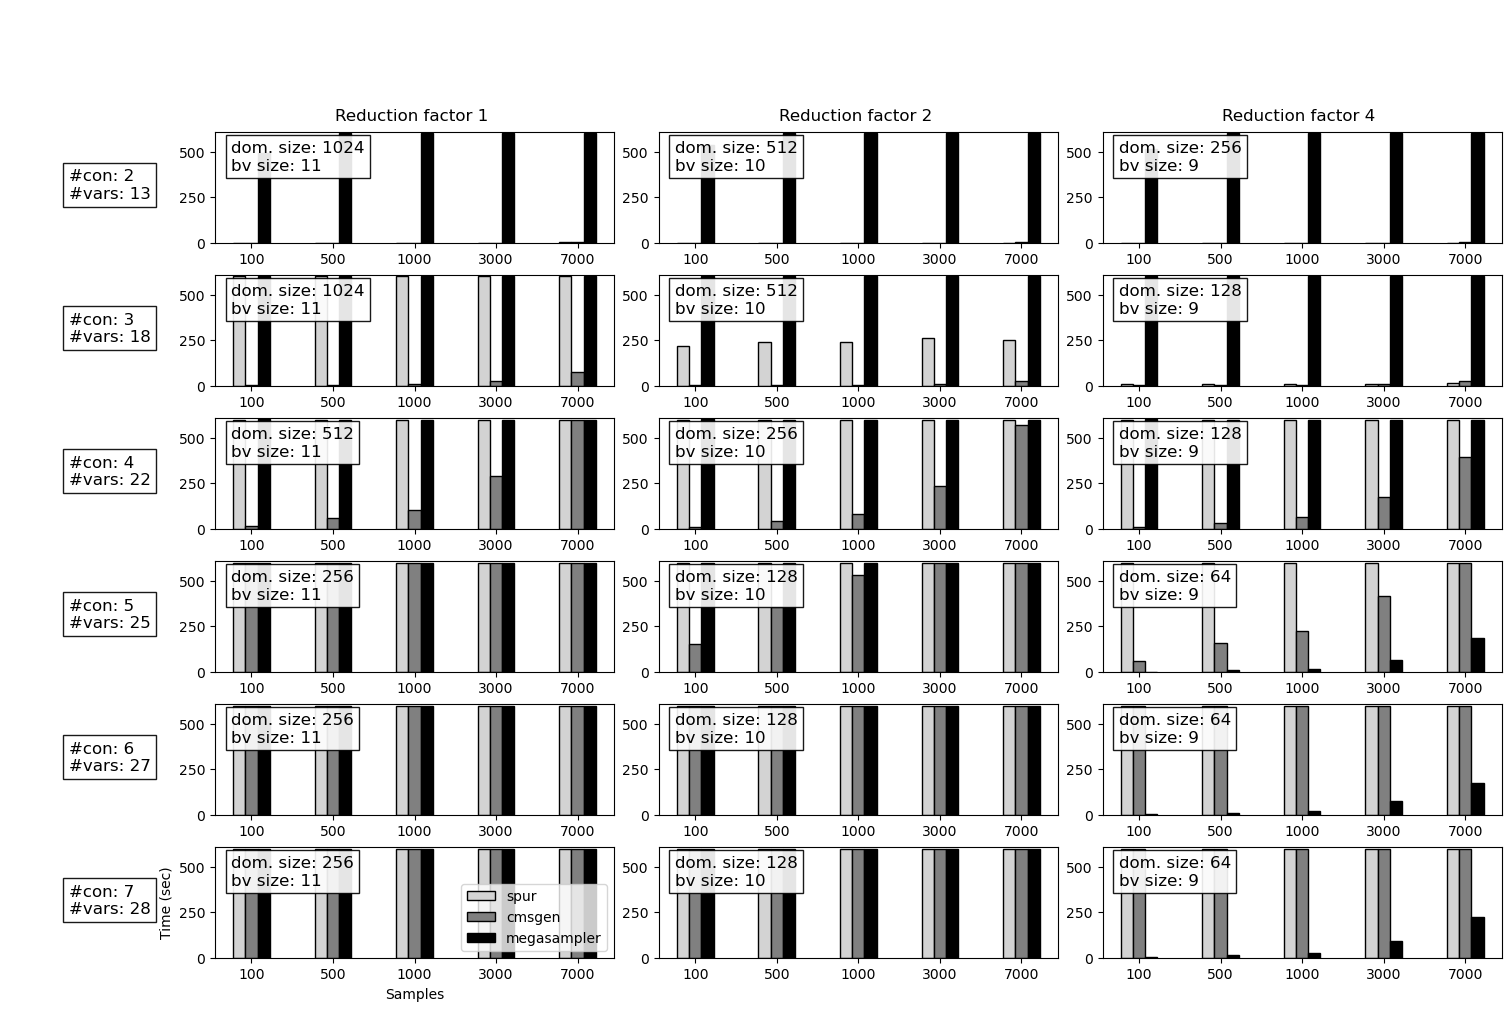

In [192]:
# plot all results
num_cons = [2,3,4,5,6,7]
rfs = [1,2,4]

fig, axs = plt.subplots(len(num_cons)+1,len(rfs)+1, figsize=(15,10), 
                        layout='constrained', width_ratios=np.concatenate([[1], np.repeat(4,len(rfs))]))

axs[0,0].set_axis_off()

for (c,i) in zip(num_cons, range(len(num_cons))):
    (_, _, _, num_bits, max_int_bv) = get_info_from_num_con_and_red_fac(problem='roads', num_con=c, 
                                                                        # the reduction factor is irrelevant
                                                                        rf=1)
    num_vars = __get_num_vars(problem='roads', num_con=c)
    axs[i+1,0].text(0.59,0.4,f'#con: {c}\n#vars: {num_vars}',
                    bbox=dict(facecolor='white', alpha=0.9),
                    fontsize=12)
    axs[i+1,0].axis('off')

for (r,j) in zip(rfs, range(len(rfs))):
    axs[0,j+1].text(0.3,0,f'Reduction factor {r}', fontsize=12)
    axs[0,j+1].axis('off')

for (c,i) in zip(num_cons, range(len(num_cons))):
    for (r,j) in zip(rfs, range(len(rfs))):

        files = glob.glob(f'roads_results_con_{c}_rf_{r}_*.csv')
        if len(files) > 0:
            file  = files[0]
            df = pd.read_csv(file, index_col=False)
            x = df.samples.unique()
            ax = axs[i+1,j+1]

            num_samples_bars = df.samples.unique()
            means = {i: df[df.backend == i].total_time_mean for i in df.backend.unique()}

            x = np.arange(len(num_samples_bars))  # the label locations
            width = 0.15  # the width of the bars
            multiplier = 0

            colors = {'spur': '#D3D3D3', 'cmsgen': '#808080', 'megasampler': '#000000'}

            for attribute, measurement in means.items():
                offset = width * multiplier
                rects = ax.bar(x + offset, measurement, width, label=attribute, color=colors[attribute], edgecolor='black')
                multiplier += 1

            ax.set_xticks(x + width, num_samples_bars)
            ax.set_ylim(0, 610)
            
            if i == len(num_cons)-1 and j == 0:
                ax.set_ylabel('Time (sec)')
                ax.set_xlabel('Samples')
                ax.legend(loc='lower right', ncols=1)

            (_, _, _, num_bits, max_int_bv) = get_info_from_runtime_filename(file)
            ax.text(-.1, 400, f'dom. size: {max_int_bv+1}\nbv size: {num_bits}', 
                    bbox=dict(facecolor='white', alpha=0.9), fontsize=12)

            # for backend in df.backend.unique():
            #     # if backend not in ['megasampler']:
            #     if backend not in []:
            #         means = df[df.backend == backend].total_time_mean
            #         stds  = df[df.backend == backend].total_time_std
            #         ax.plot(x, means, label=backend, marker='.')    
            #         ax.fill_between(x, means - stds, means + stds, alpha=0.2)                
            #     ax.set_ylim(0, 610)
        else:
            axs[i+1,j+1].set_axis_off()
# plt.legend()
plt.savefig('roads_performance_results.pdf')
plt.show();
            
            

In [ ]:
az.plot_forest(traces_roads, combined=True, model_names=backends, hdi_prob=0.95, kind='ridgeplot', figsize=(7,7), ess=True);

NameError: name 'traces_roads' is not defined

## Books

In [ ]:
y_books = np.array([3, 12, 1, 21, 86, 16, 2, 24, 5, 184, 822, 163, # fix (country, age) count for all booktypes
                    40, 102, 13, 58, 253, 38, 18, 104, 40, 19, 147, 25, 52, 220, 35, # fix (age, booktype) count for all countries (ignores booktype F)
                    1, 3, 6, 8, 36, 5, 1, 14, 2, 1, 10, 13, 3, 43, 4] # fix (booktype, country) and count for all ages (ignores booktype F and USA)
                    )
cases = [12, 27, 42] # 
bound = cases[2]
reduction_factor = 3
[int(i/reduction_factor) for i in y_books[:bound]]
# models.A_BOOKS[:c,:];

In [78]:
### this data ignores for the cases (age,booktype) and (booktype,country)
y_books = np.array([3, 12, 1, 21, 86, 16, 2, 24, 5, 184, 822, 163, # fix (country, age) count for all booktypes
                    40, 102, 13, 58, 253, 38, 18, 104, 40, 19, 147, 25, 52, 220, 35, # fix (age, booktype) count for all countries (ignores booktype F)
                    1, 3, 6, 8, 36, 5, 1, 14, 2, 1, 10, 13, 3, 43, 4] # fix (booktype, country) and count for all ages (ignores booktype F and USA)
                )

num_samples = [ 100,  500,  1000, 3000, 7000]
TIMEOUT = 60*10 # seconds (10min)

cases = [12, 27, 42]

bound = cases[2]
reduction_factor = 3

## Automatically calculated necessary bits
num_bits = int(np.log2((y_books[:bound]/reduction_factor).max()))+1;
max_int_bits = max([int(np.log2((total/summands)+1))+1 
                    for (summands,total) in zip(models.A_BOOKS[:bound,:].sum(axis=1), (y_books[:bound]/reduction_factor))])
max_int_bv = 2**max_int_bits-1


(g, num_bits, num_vars) = models.get_books_sat(bound=bound, y_reduction_factor=reduction_factor, num_bits=num_bits, max_int_bv=max_int_bv)
(s, num_vars) = models.get_books_smt(bound=bound, y_reduction_factor=reduction_factor, max_int=max_int_bv)

backends = ['spur', 'cmsgen', 'megasampler']



##############################################################

# logger
logger = logging.getLogger(f"Books runtime | case {bound} | bits {num_bits} | max_int {max_int_bv}")

# timeouts
timeout = {
    'spur': False,
    'cmsgen': False,
    'megasampler': False
}
### Global variables for the cell used in the experiments

def executing_books_with_backend(samples, backend):
    logger.info(f'Running books with {backend} and generating {samples} samples')

    if timeout[backend]:
        return (600, 0, None)

    # catch TIMEOUT exception
    try:
        (time_sample_gen, time_mcmc, trace) = \
            mcmc.sample_mh_trace_from_z3_model(
                backend=backend,
                z3_problem=g,
                num_bits=num_bits,
                num_vars=num_vars,
                timeout_sampler=TIMEOUT,
                num_samples=samples,
                time_execution=True) \
        if backend in ['spur','cmsgen'] \
        else mcmc.sample_mh_trace_from_z3_model(
                backend=backend,
                z3_problem=s,
                reweight_samples=True,
                timeout_sampler=TIMEOUT,
                num_samples=samples,
                time_execution=True)
    except Exception as exception:
        logger.error(exception.__class__.__name__)
        (time_sample_gen, time_mcmc, trace) = (600, 0, None)
    
    timeout[backend] = (time_sample_gen + time_mcmc) >= 600

    logger.info(f'Execution finished in {time_sample_gen + time_mcmc} seconds')

    return (time_sample_gen, time_mcmc, trace)

traces_books = [
    (samples,
    [[executing_books_with_backend(samples, backend)
    for rep in range(3)] for backend in backends])
    for samples in num_samples]

Parsing input file: megasampler_input/z3_problem.smt2
Number of formulas in file: 186
-------------FORMULA STATISTICS-------------
Arrays 0
Bit-vectors 0
Bools 0
Bits 0
Uninterpreted functions 0
Ints 72
Reals 0
Formula tree depth 2
--------------------------------------------
starting MeGASampler
Formula is unsat
---------SOLVING STATISTICS--------
total time: 0.0546148
Epochs: 0
MAX-SMT calls: 1
SMT calls: 0
Assignments considered (with repetitions): 0
Models (with repetitions): 0
Unique models (# samples in file): 0
-----------------------------------
Samples have been reweighted. The sampler generated 0 and the reweighting process has generated 0 (according to the unnormalized posterior probability specified in the input parameter `f`).



In [ ]:
data_books = {
    'samples':  [],
    'backend':  [],
    'num_executions': [],
    'sampling_time_mean': [],
    'sampling_time_std': [],
    'metropolis_time_mean': [],
    'metropolis_time_std': [],
    'total_time_mean': [],
    'total_time_std': []
}
for (num_samples, results_per_backend) in traces_books:
    for (backend, results) in zip(backends,results_per_backend):
        sampling_times = np.array([sampling_time for (sampling_time, _, _) in results])
        metropolis_times = np.array([metropolist_time for (_, metropolist_time, _) in results])
        total_times = sampling_times + metropolis_times
        data_books['samples'].append(num_samples)
        data_books['backend'].append(backend)
        data_books['num_executions'].append(sampling_times.size)
        data_books['sampling_time_mean'].append(sampling_times.mean())
        data_books['sampling_time_std'].append(sampling_times.std())
        data_books['metropolis_time_mean'].append(metropolis_times.mean())
        data_books['metropolis_time_std'].append(metropolis_times.std())
        data_books['total_time_mean'].append(total_times.mean())
        data_books['total_time_std'].append(total_times.std())
df_real_books = pd.DataFrame(data_books)
df_real_books.to_csv(f'books_results_case_{bound}_rf_{reduction_factor}_bits_{num_bits}_max_int_{max_int_bv}.csv')  

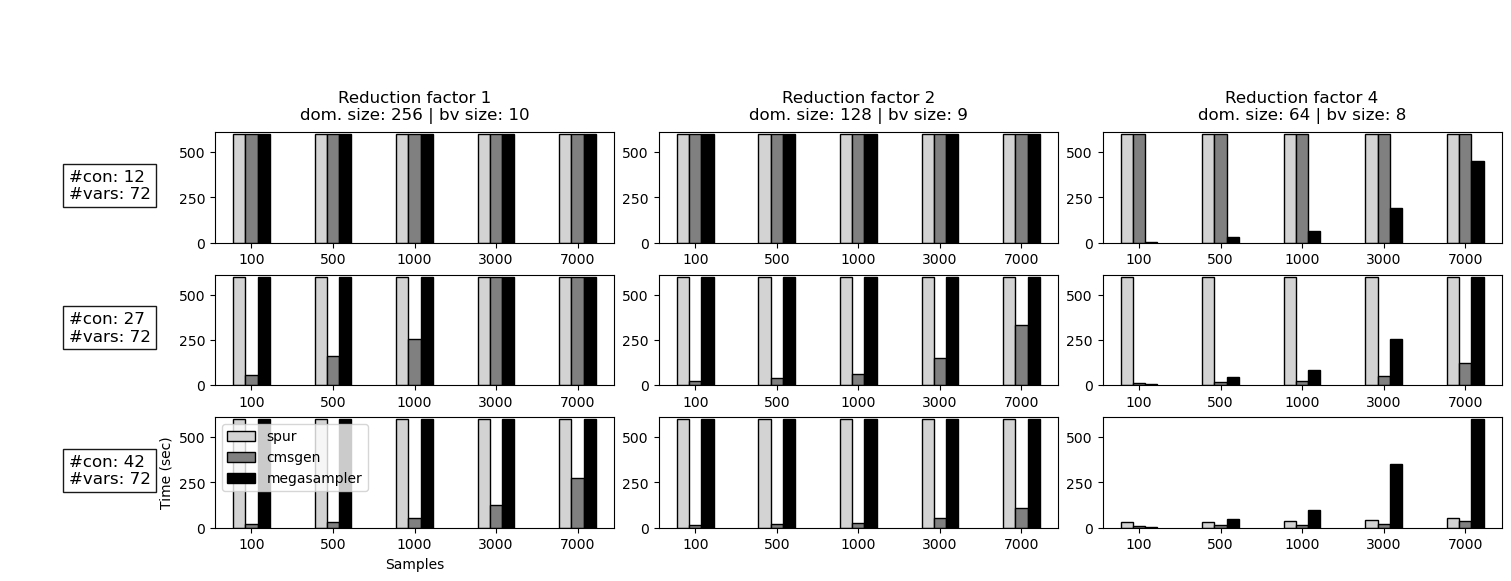

In [191]:
# plot all results
bounds = [12, 27, 42]
rfs = [1,2,4]

fig, axs = plt.subplots(len(bounds)+1,len(rfs)+1, figsize=(15,5.7), 
                        layout='constrained', width_ratios=np.concatenate([[1], np.repeat(4,len(rfs))]))

axs[0,0].set_axis_off()

for (c,i) in zip(bounds, range(len(bounds))):
    (_, _, _, num_bits, max_int_bv) = get_info_from_num_con_and_red_fac(problem='books', num_con=c, 
                                                                        # the reduction factor is irrelevant
                                                                        rf=1)    
    axs[i+1,0].text(0.59,0.4,f'#con: {c}\n#vars: 72',
                    bbox=dict(facecolor='white', alpha=0.9),
                    fontsize=12)
    axs[i+1,0].axis('off')

for (r,j) in zip(rfs, range(len(rfs))):
    (_, _, _, num_bits, max_int_bv) = get_info_from_num_con_and_red_fac(problem='books', rf=r, 
                                                                        # the number of constraints is irrelevant
                                                                        num_con=42) 
    axs[0,j+1].text(0.5, 0.0,f'Reduction factor {r}\ndom. size: {max_int_bv+1} | bv size: {num_bits}',
                    fontsize=12, horizontalalignment='center')
    axs[0,j+1].axis('off')

for (c,i) in zip(bounds, range(len(bounds))):
    for (r,j) in zip(rfs, range(len(rfs))):

        files = glob.glob(f'books_results_case_{c}_rf_{r}_*.csv')
        if len(files) > 0:
            file  = files[0]
            df = pd.read_csv(file, index_col=False)
            x = df.samples.unique()
            ax = axs[i+1,j+1]

            num_samples_bars = df.samples.unique()
            means = {i: df[df.backend == i].total_time_mean for i in df.backend.unique()}

            x = np.arange(len(num_samples_bars))  # the label locations
            width = 0.15  # the width of the bars
            multiplier = 0                       

            colors = {'spur': '#D3D3D3', 'cmsgen': '#808080', 'megasampler': '#000000'}

            for attribute, measurement in means.items():
                offset = width * multiplier
                rects = ax.bar(x + offset, measurement, width, label=attribute, color=colors[attribute], edgecolor='black')
                multiplier += 1

            ax.set_xticks(x + width, num_samples_bars)
            ax.set_ylim(0, 610)
            
            if i == len(bounds)-1 and j == 0:
                ax.set_ylabel('Time (sec)')
                ax.set_xlabel('Samples')
                ax.legend(loc='upper left', ncols=1)
            
            # (_, _, _, num_bits, max_int_bv) = get_info_from_runtime_filename(file)
            # ax.text(-.1, 400, f'dom. size: {max_int_bv}\nbv size: {num_bits}', 
            #         bbox=dict(facecolor='white', alpha=0.9), fontsize=12)

            # for backend in df.backend.unique():
            #     # if backend not in ['megasampler']:
            #     if backend not in []:
            #         means = df[df.backend == backend].total_time_mean
            #         stds  = df[df.backend == backend].total_time_std
            #         ax.plot(x, means, label=backend, marker='.')    
            #         ax.fill_between(x, means - stds, means + stds, alpha=0.2)                
            #     ax.set_ylim(0, 610)
        else:
            axs[i+1,j+1].set_axis_off()
# plt.legend()
plt.savefig('books_performance_results.pdf')
plt.show();

### Posterior plots and some diagnosis for CMSGen since it can handle the complete problem

Since CMSGen scales to the complete books problem, now we look into its trace plots; so that it can be compared with the results by Hazelton.

In [2]:
## Load saved trace with results
traces_books_cmsgen_original_problem = az.from_netcdf('trace_books_cmsgen_samples_7000_original_problem.nc')

In [3]:
## Look at diagnostics first
## The ESS and MCSE look good
az.summary(traces_books_cmsgen_original_problem.posterior.sel(chain=[0]), var_names=['x58'])

arviz - WARNING - Shape validation failed: input_shape: (1, 7000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x58,181.484,7.71,170.0,194.0,0.091,0.065,7142.0,7060.0,NaN


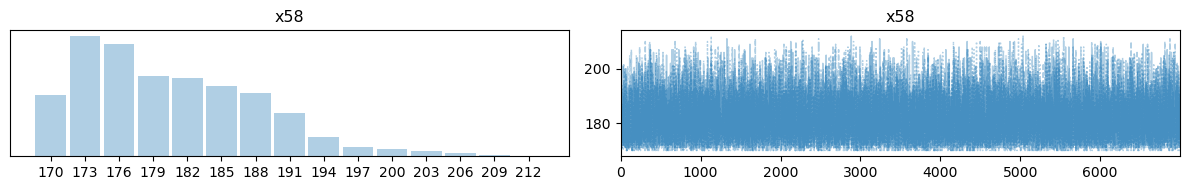

In [4]:
## Trace plots
## They look good, they differ a bit from Hazelton's because we did not model the concrete problem
axs = az.plot_trace(traces_books_cmsgen_original_problem, combined=True, compact=True, var_names=['x58'], trace_kwargs={'color': 'black'})
# Modify the axes separately
# axes = axs.ravel()
# for line in axes[1].get_lines():
#     line.set_color("black")
#     line.set_alpha(0.2)
# axes[1].set_title("SAT-Metropolis (CMSGen)")
# axes[1].set_xlabel("Step")
# axes[1].set_yticks([170, 175, 180 , 185, 190, 195])
# axes[1].set_ylim(170, 195)
# axes[1].set_ylabel("(USA, 51, E)")

### Efficiency comparison with Hazelton's method

Here we perform a small comparison of the efficiency of sat-metropolis with CMSGen in the Books problem, as it can handle it. In other words, is sat-metropolis with CSMGen close to the performance of Hazelton's method?

First we check the quality of the samples we generated by looking into the mean ESS for all variables. This metric tells us how many of the samples we generated had actual information. The value is very close to 7000, which indicates very good quality samples.

In [5]:
az.ess(traces_books_cmsgen_original_problem.posterior.sel(chain=[0]), var_names=[f'x{i}' for i in range(72)]).to_array().mean().item()

6944.123912674674

Now we retrieve the average running time of sat-metropolis (CMSGen) for this case study

In [6]:
df_comp_haz = pd.read_csv('books_results_case_42_rf_1_bits_10_max_int_255.csv')
running_time_cmsgen_books_7000 = df_comp_haz[(df_comp_haz.backend == 'cmsgen') & (df_comp_haz.samples == 7000)].total_time_mean.item()

The arrays below contain:
- `ess_hazelton`: ESS values for all variables and algorithms considered by Hazelton's 
- `hazelton_running_times`: Running time of three execution of each algorithm considered by Hazelton

We obtain the data by running Hazenton's code (https://github.com/MartinLHazelton/DynamicLatticeBasis/) for 200000 samples. We selected 200000 samples as this is the minimum value that achieves an ESS similar to sat-metropolis (CMSGen) for this problem.

In [65]:
# ESS values for all values and algorithms for one of the runs
ess_hazelton = np.array([
    [5673, 3478, 3478, 3645, 2911, 2764,   17,    22,    22,     0,     0],
    [5919, 3555, 3555, 3843, 2887, 2758,   17,    22,    22,     0,     0],
    [3126, 1471, 1471, 3083, 1785, 1681,    0,  8361,  8361,     0,     0],
    [5544, 2777, 2777, 4924, 2952, 2846,  521,   337,   337,    99,    95],
    [6868, 3029, 3029, 5314, 2973, 2832,  496,   309,   309,    94,   115],
    [5485, 1624, 1624, 4633, 2027, 1974,  789,   256,   256,   441,   181],
    [2516, 1433, 1433, 1918, 1358, 1343,  106,    56,    56,    98,    57],
    [2748, 1842, 1842, 2075, 1478, 1436,  239,   161,   161,    17,    16],
    [2229, 1786, 1786, 2049, 1417, 1374,  263,   166,   166,    11,    14],
    [4140, 2262, 2262, 3203, 2234, 2150,  375,   148,   148,   136,   101],
    [4119, 2478, 2478, 2894, 2152, 2063,  301,   168,   168,    32,    33],
    [2809, 1894, 1894, 2426, 1577, 1543,  369,   217,   217,    16,    18],
    [9940, 4596, 4596, 2389, 1523, 1462,  187,   148,   148,    44,    32],
    [6650, 3478, 3478, 2557, 1421, 1359,  187,   159,   159,    26,    33],
    [1768, 1068, 1068, 1939, 1383, 1323,    0,   345,   345,    59,    65],
    [9913, 3284, 3284, 2535, 1174, 1139,  245,   135,   135,    15,     9],
    [6408, 2578, 2578, 2740, 1384, 1339,  212,   135,   135,     8,     6],
    [2738, 1120, 1120, 2722, 1353, 1312,  342,   168,   168,    15,     8],
    [13106, 8688, 8688, 3146, 2445, 2332,  119,   502,   502,    57,    57],
    [3345, 2774, 2774, 2914, 2388, 2312,  275,   231,   231,    16,    21],
    [2119, 1816, 1816, 2444, 2171, 2110,  298,   229,   229,    15,    30],
    [10825, 3798, 3798, 2543, 1219, 1175,  212,   129,   129,    13,    10],
    [6246, 2841, 2841, 2784, 1539, 1491,  185,   139,   139,    12,     7],
    [2693, 1226, 1226, 2695, 1551, 1499,  321,   179,   179,    12,     8],
    [5885, 2578, 2578, 3384, 2020, 1945,   11,   630,   630,    76,    82],
    [10200, 5186, 5186, 3530, 2034, 1967,   11,    46,    46,    87,   107],
    [11934, 8247, 8247, 2784, 2010, 1957,    0,    42,    42,   142,   221],
    [4630, 1381, 1381, 2772, 1239, 1203,  460,   260,   260,    16,    35],
    [10760, 3795, 3795, 3097, 1492, 1439,  286,   187,   187,    18,    15],
    [11007, 5164, 5164, 2844, 1425, 1378,  322,   251,   251,    37,    10],
    [4294, 2045, 2045, 3276, 1584, 1525,  529,   850,   850,   118,   211],
    [12839, 8434, 8434, 3352, 2504, 2427,  209,   349,   349,    77,    75],
    [12993, 9468, 9468, 3113, 2435, 2370,  189,   346,   346,   101,    71],
    [4748, 1522, 1522, 2894, 1345, 1305,  439,   261,   261,    25,    36],
    [11069, 4282, 4282, 3256, 1687, 1626,  270,   183,   183,    22,    19],
    [11494, 5921, 5921, 3021, 1746, 1691,  291,   256,   256,    34,    11],
    [5981, 2394, 2394, 4107, 2282, 2202,    6,   684,   684,   113,   239],
    [5371, 2382, 2382, 4433, 2412, 2319,    6,   530,   530,   141,   236],
    [3246, 1764, 1764, 3655, 2049, 1965,    0,  1728,  1728,   318,   435],
    [5128, 1199, 1199, 3282, 1175, 1105,  435,   289,   289,    67,    67],
    [5621, 1660, 1660, 3859, 1592, 1508,  361,   236,   236,    70,    69],
    [4468, 1616, 1616, 3707, 1794, 1708,  439,   368,   368,    82,    77],
    [2661, 1569, 1569, 1944, 1397, 1353,  311,    77,    77,   160,   129],
    [1844, 1250, 1250, 1784, 1028, 1003,  217,   156,   156,    66,    45],
    [1508,  989,  989, 1566,  787,  758,  234,   162,   162,    48,    61],
    [4177, 1381, 1381, 2938, 1332, 1315,  401,   258,   258,    58,    46],
    [3447, 1517, 1517, 3064, 1324, 1259,  285,   155,   155,    46,    35],
    [2552, 1421, 1421, 2462, 1283, 1124,  324,   187,   187,    40,    37],
    [5168, 2549, 2549, 3214, 1998, 1928,  197,   101,   101,   132,   128],
    [4817, 2567, 2567, 3153, 2083, 2023,  197,    55,    55,   114,   113],
    [2225, 1638, 1638, 2581, 1855, 1778,    0,    25,    25,   229,   157],
    [3771, 1047, 1047, 2472, 1020,  935,  243,   127,   127,    38,    20],
    [3894, 1245, 1245, 2729, 1148, 1106,  192,   125,   125,    32,    19],
    [2568,  968,  968, 2604, 1305, 1274,  303,   139,   139,    44,    41],
    [3281, 2345, 2345, 3264, 2447, 2374,  676,   134,   134,   177,   131],
    [3076, 2323, 2323, 3113, 2200, 2150,  462,   269,   269,    91,    82],
    [2404, 1891, 1891, 2790, 2037, 1974,  456,   286,   286,    87,   145],
    [3861, 1186, 1186, 2593, 1201, 1056,  239,   107,   107,    28,    15],
    [4070, 1428, 1428, 2875, 1364, 1332,  193,   108,   108,    26,    12],
    [2666, 1148, 1148, 2668, 1431, 1398,  309,   146,   146,    52,    32],
    [5388, 2323, 2323, 2715, 1870, 1784,  290,   159,   159,   140,   138],
    [4135, 2250, 2250, 2890, 2152, 2068,  290,   164,   164,   146,   147],
    [1969, 1430, 1430, 2475, 1738, 1664,    0,   221,   221,   175,   233],
    [4596, 1315, 1315, 2893, 1218, 1207,  403,   193,   193,    57,    65],
    [4487, 1596, 1596, 3212, 1337, 1302,  254,   153,   153,    53,    49],
    [2965, 1226, 1226, 3004, 1328, 1295,  319,   203,   203,    66,    48],
    [5120, 2551, 2551, 3997, 1943, 1866,    0, 21265, 21265,   298,   130],
    [4691, 2622, 2622, 4278, 2979, 2887,    0,   112,   112,   173,   136],
    [3905, 2245, 2245, 4098, 2844, 2760,    0,   109,   109,   161,   154],
    [4816, 1478, 1478, 2935, 1206, 1182,  380,   183,   183,    40,    45],
    [4531, 1751, 1751, 3279, 1466, 1427,  257,   140,   140,    38,    37],
    [2978, 1404, 1404, 3089, 1584, 1555,  319,   190,   190,    66,    36]]).T

# 200000 samples (needed to obtain a similar ESS)
hazelton_running_times = np.array([
    [10.241, 3.264, 3.163,12.840, 6.052, 6.867,10.686, 7.006, 7.060, 4.481, 3.580],
    [9.590, 3.163, 3.169,12.774, 6.049, 5.981, 9.737, 6.632, 6.683, 4.172, 3.281],
    [9.757, 3.115, 3.322,13.600, 6.289, 6.136,10.250, 6.833, 6.529, 4.297, 3.421]
  ]).T

The table below shows that with 200000 samples only the first dynamic lattice basis algorithm achieves a similar performance than sat-metropolis (CMSGen).

Therefore, we compare the ratio between these two running times, and the outcome is that **sat-metropolis is 28x times slower than the best dynamic lattice basis algorithm for this problem**.

In [97]:
running_time_cmsgen_books_7000/hazelton_running_times.mean(axis=1)[0]

27.81839094017589

Hazelton's work also considers the average number high quality samples each algorithm generates per second. This is computed by computing the average ESS over all variables and divide it by running time.

In [95]:
ess_hazelton.mean(axis=1)/hazelton_running_times.mean(axis=1)

array([529.72770493, 806.02861035, 796.67754299, 232.12373132,
       287.8194671 , 268.63411294,  24.57508775,  93.47980069,
        94.39744475,  18.21428571,  21.87479738])

We do the same for sat-metropolis

In [96]:
(az.ess(traces_books_cmsgen_original_problem.posterior.sel(chain=[0]), var_names=[f'x{i}' for i in range(72)]).to_array().mean()/running_time_cmsgen_books_7000).item()

25.309939118148332

We observe that sat-metropolis generates 25 samples per second, which is slower than most of the algorithms considered by Hazelton. However, it it is better than full markov basis algorithms and comparable with Gibbs $\alpha=100$. 

Finally, we highlight that, thanks to the uniform sampling we use, the traces produced by sat-metropolis are much smaller in size. To obtain an average 7000 ESS we only need 7000 samples. However, for the same average ESS, it is required to sample at least 200000. In other words, **the best dynamic lattice basis method requires 28x times more samples than sat-metropolis to obtain a chain of similar quality (measured as ESS)**.

In [130]:
200000/7000

28.571428571428573

# Roads and Books summary table

In this section, we produce a pandas dataset that summarizes number of variables & constraints (original and bit-blasted), domain sizes and running times. We start by obtaining the information from the .cnf files produces by the Z3 bit-blasting function; which we access via the `save_dimacs` funciton in this library.

In [ ]:
cases = [12, 27, 42]
rfs = [1,2,3,4]
for (c, r) in [(c,r) for c in cases for r in rfs]:

    ### this data ignores for the cases (age,booktype) and (booktype,country)
    y_books = np.array([3, 12, 1, 21, 86, 16, 2, 24, 5, 184, 822, 163, # fix (country, age) count for all booktypes
                        40, 102, 13, 58, 253, 38, 18, 104, 40, 19, 147, 25, 52, 220, 35, # fix (age, booktype) count for all countries (ignores booktype F)
                        1, 3, 6, 8, 36, 5, 1, 14, 2, 1, 10, 13, 3, 43, 4] # fix (booktype, country) and count for all ages (ignores booktype F and USA)
                    )    

    ## Automatically calculated necessary bits
    num_bits = int(np.log2((y_books[:c]/r).max()))+1;
    max_int_bits = max([int(np.log2((total/summands)+1))+1 
                        for (summands,total) in zip(models.A_BOOKS[:c,:].sum(axis=1), (y_books[:c]/r))])
    max_int_bv = 2**max_int_bits-1

    (g, num_bits, num_vars) = models.get_books_sat(bound=c, y_reduction_factor=r, num_bits=num_bits, max_int_bv=max_int_bv)
    
    mcmc.sat.save_dimacs(g,f'cnf_files/books_cnf_case_{c}_rf_{r}.cnf')

In [ ]:
## generate dimacs verion of Z3 problems to get number of clauses and variables after bitblasting
num_cons = [2,3,4,5,6,7]
rfs = [1,2,3,4]
y = np.array([1087, 1008, 1068, 1204, 1158, 1151, 1143])
for (c, r) in [(c,r) for c in num_cons for r in rfs]:
    samples = 10
    
    ## Automatically calculated necessary bits
    num_bits = int(np.log2((y[:c]/r).max()))+1;
    max_int_bits = max([int(np.log2((total/summands)+1))+1 
                        for (summands,total) in zip(models.__gen_conf_matrix(np.array([1,2,3,4,5,6,7][:c])).sum(axis=1), (y[:c]/r))])
    max_int_bv = 2**max_int_bits-1
 
    ## Get models
    (g, num_bits, num_vars) = models.get_roads_sat(num_bits = num_bits,
                                                   max_int_bv = max_int_bv,
                                                   num_con=c,
                                                   y_reduction_factor=r)
    
    mcmc.sat.save_dimacs(g,f'cnf_files/roads_cnf_con_{c}_rf_{r}.cnf')
    
    
    

[(1, 2), (1, 3), (2, 3)]
[(1, 2), (1, 3), (2, 3)]
[(1, 2), (1, 3), (2, 3)]
[(1, 2), (1, 3), (2, 3)]
[(1, 2), (1, 3), (2, 3)]
[(1, 2), (1, 3), (2, 3)]
[(1, 2), (1, 3), (2, 3)]
[(1, 2), (1, 3), (2, 3)]
[(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
[(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
[(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
[(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
[(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
[(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
[(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
[(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
[(1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
[(1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
[(1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
[(1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
[(1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
[(1

## Summary table

The code below produces the summary table.

In [185]:
def get_scalability_summary_table(symbols: bool = False):
    """
    Function to produces a summary table with #variables & #constraints, domain sizes and running times for 7000 samples for all backends.
    The function requires that the corresponding .csv files produced by the benchmarking sections for rodas and books above are generated.
    Furthermore, the function requires that the .cnf files containing the bit-blasted version of the models are generated using the functions in the previous two cells.
    """
    scalability_summary_data  = {
        'problem': [],
        '#vars': [],
        '#constraints': [],
        '#vars (bit-blasted)': [],
        '#clauses (bit-blasted)': [],
        'reduction': [],
        'bv size': [],
        'dom. size': [],
        'clause/var': [],
        'clause/var (bit-blasted)': [],
        'spur': [],
        'cmsgen': [],
        'megasampler': [],
    }

    __get_symbol = lambda x: '✔' if x else '✘'

    for file in glob.glob(f'roads_results_*.csv')+glob.glob(f'books_results_*.csv'):
        parsed_filename = file.split('_')
        problem    = parsed_filename[0]
        num_con    = int(parsed_filename[3])
        red_fac    = int(parsed_filename[5])
        num_bits   = int(parsed_filename[7])
        max_int_bv = int(parsed_filename[10].split('.')[0])
        df = pd.read_csv(file)
        if red_fac < 5:
            scalability_summary_data['problem'].append(problem)
            scalability_summary_data['#vars'].append(__get_num_vars(problem, num_con))
            scalability_summary_data['#constraints'].append(num_con)
            scalability_summary_data['reduction'].append(red_fac)
            scalability_summary_data['bv size'].append(num_bits)
            scalability_summary_data['dom. size'].append(max_int_bv)
            scalability_summary_data['clause/var'].append(num_con/__get_num_vars(problem, num_con))

            spur_runtime   = df[(df.samples == 7000) & (df.backend == 'spur')].total_time_mean.values.item()
            scalability_summary_data['spur'].append(spur_runtime if not symbols else __get_symbol(spur_runtime < 600))
            cmsgen_runtime = df[(df.samples == 7000) & (df.backend == 'cmsgen')].total_time_mean.values.item()
            scalability_summary_data['cmsgen'].append(cmsgen_runtime if not symbols else __get_symbol(cmsgen_runtime < 600))
            megasampler_runtime = df[(df.samples == 7000) & (df.backend == 'megasampler')].total_time_mean.values.item()
            scalability_summary_data['megasampler'].append(megasampler_runtime if not symbols else __get_symbol(megasampler_runtime < 600))

            # not very elegant...
            filename = f'cnf_files/roads_cnf_con_{num_con}_rf_{red_fac}.cnf'
            if problem == 'books':
                filename = f'cnf_files/books_cnf_case_{num_con}_rf_{red_fac}.cnf'

            with open(filename, 'r') as file:
                first_line = file.readline()
                num_vars    = int(first_line[:-1].split(' ')[2])
                num_clauses = int(first_line[:-1].split(' ')[3])
                scalability_summary_data['#vars (bit-blasted)'].append(num_vars)
                scalability_summary_data['#clauses (bit-blasted)'].append(num_clauses)
                scalability_summary_data['clause/var (bit-blasted)'].append(num_clauses/num_vars)
                
                
    
    return pd.DataFrame(scalability_summary_data).sort_values(by=['#constraints','reduction'])


In [193]:
df_combined = get_scalability_summary_table(symbols=True)
df_combined.to_latex('table.tex',float_format="{:.2f}".format, index=False) # save to latex

In [195]:
df_combined

,problem,#vars,#constraints,#vars (bit-blasted),#clauses (bit-blasted),reduction,bv size,dom. size,clause/var,clause/var (bit-blasted),spur,cmsgen,megasampler
13,roads,13,2,203,713,1,11,1023,0.153846,3.512315,✔,✔,✘
19,roads,13,2,183,641,2,10,511,0.153846,3.502732,✔,✔,✘
7,roads,13,2,148,499,3,9,255,0.153846,3.371622,✔,✔,✘
3,roads,13,2,162,565,4,9,255,0.153846,3.487654,✔,✔,✘
5,roads,18,3,646,2722,1,11,1023,0.166667,4.213622,✘,✔,✘
12,roads,18,3,586,2464,2,10,511,0.166667,4.204778,✔,✔,✘
15,roads,18,3,512,2154,3,9,255,0.166667,4.207031,✔,✔,✘
18,roads,18,3,516,2168,4,9,127,0.166667,4.201550,✔,✔,✘
4,roads,22,4,1409,6491,1,11,511,0.181818,4.606813,✘,✘,✘
16,roads,22,4,1267,5827,2,10,255,0.181818,4.599053,✘,✔,✘


In [5]:
print(f'SPUR successful experiments: {df_combined['spur'].apply(lambda x: x<600).sum()} out of {df_combined['spur'].shape[0]}')
print(f'CMSGen successful experiments: {df_combined['cmsgen'].apply(lambda x: x<600).sum()} out of {df_combined['cmsgen'].shape[0]}')
print(f'MegaSampler successful experiments: {df_combined['megasampler'].apply(lambda x: x<600).sum()} out of {df_combined['megasampler'].shape[0]}')

SPUR successful experiments: 8 out of 35
CMSGen successful experiments: 18 out of 35
MegaSampler successful experiments: 7 out of 35


# Haplotypes

The experiment below considers:
* 32 Haplotypes
* 5 placings in the haplotype ($2^5 = 32$)
* 100 genotypes

First, we generate a dataset of genotypes from a set of input
haplotype probabilities. The goal of the experiments is recovering
those probabilities after sampling.

In [131]:
# config of the experiment
bits_per_haplotype = 5
num_haplotypes = 2**bits_per_haplotype
num_genotypes = 100

# list of distinct haplotypes
haplotypes = list(map(list, itertools.product([0, 1], repeat=bits_per_haplotype)))

# list of haplotypes probabilities
haplotypesProb = [
    0.0056,   0.004,                0.00368,  0.1,                 
    0.005681, 0.09,                 0.00468,  0.003,    
    0.08,     0.006147,             0.00595,  0.0071,   
    0.00345,  0.00632,              0.1,      0.0029,   
    0.0071,   0.006147,             0.085,    0.0045671,
    0.003379, 0.1,                  0.00461,  0.00614,             
    0.075,    0.08,                 0.00761,  0.004321, 
    0.09,     0.009217900000000112, 0.0134,   0.075]

# there must be a haplotype probability for each haplotype
if not (len(haplotypes) == len(haplotypesProb)):
    raise RuntimeError('The size of the list of haplotype probabilities does not match the list of distinct haplotypes')

# dict to store haplotype counts after sampling
haplotypesnumber = {}
for i in range(32):
    haplotypesnumber[str(haplotypes[i])] = 0

genotypes = []
d = {'h_1': [], 'h_2': [], 'g': []} # NOTE: added by Raúl

# seeds not working...
np.random.seed(2024)
random.seed(2024)

# we generate `num_genotypes` by sampling pairs of haplotypes according to their probabilities
for i in range(num_genotypes):
    h1 = np.random.choice(np.arange(num_haplotypes), p=haplotypesProb) # samples one haplotype (from 0 to 31) with probabilities above
    h2 = np.random.choice(np.arange(num_haplotypes), p=haplotypesProb) # samples one haplotype (from 0 to 31) with probabilities above
    genotypes.append(list(map(operator.add,haplotypes[h1],haplotypes[h2]))) # combines them to form a genotype
    d['h_1'].append(haplotypes[h1]); d['h_2'].append(haplotypes[h2]); d['g'].append(genotypes[i]); # NOTE: added by Raúl
    haplotypesnumber[str(haplotypes[h1])] = haplotypesnumber[str(haplotypes[h1])] + 1 # keeps count of sampled haplotypes 
    haplotypesnumber[str(haplotypes[h2])] = haplotypesnumber[str(haplotypes[h2])] + 1 # keeps count of sampled haplotypes 
df = pd.DataFrame(data=d)

In [132]:
df

,h_1,h_2,g
0,"[1, 0, 1, 0, 1]","[1, 1, 0, 0, 0]","[2, 1, 1, 0, 1]"
1,"[0, 0, 1, 0, 1]","[0, 0, 0, 1, 1]","[0, 0, 1, 1, 2]"
2,"[0, 0, 1, 0, 1]","[0, 0, 0, 1, 1]","[0, 0, 1, 1, 2]"
3,"[1, 1, 0, 0, 1]","[1, 1, 0, 0, 0]","[2, 2, 0, 0, 1]"
4,"[1, 0, 0, 1, 0]","[1, 0, 0, 1, 0]","[2, 0, 0, 2, 0]"
...,...,...,...
95,"[1, 0, 1, 0, 1]","[1, 1, 0, 0, 1]","[2, 1, 1, 0, 2]"
96,"[0, 1, 0, 0, 0]","[1, 0, 1, 0, 1]","[1, 1, 1, 0, 1]"
97,"[1, 1, 1, 1, 1]","[1, 1, 0, 0, 1]","[2, 2, 1, 1, 2]"
98,"[0, 1, 1, 1, 0]","[0, 1, 1, 1, 0]","[0, 2, 2, 2, 0]"


In [133]:
TIMEOUT = 60*10 # seconds (10min)

(g, num_bits, num_vars) = models.get_haplotypes_sat(
    genotypes=np.array(genotypes)
)
(s, num_vars) = models.get_haplotypes_smt(
    genotypes=np.array(genotypes)
)
backends = ['spur', 'cmsgen', 'megasampler']
# traces_haplotypes = [ 
#     mcmc.sample_mh_trace_from_z3_model(backend=backend,
#                                        z3_problem=g,
#                                        num_bits=num_bits,
#                                        num_vars=num_vars,
#                                        num_samples=1000)
#     for backend in backends ]

traces_haplotypes = [ 
    mcmc.sample_mh_trace_from_z3_model(backend=backend,
                                       z3_problem=g,
                                       num_bits=num_bits,
                                       num_vars=num_vars,
                                       timeout_sampler=TIMEOUT,
                                       num_samples=1000)
    if backend in ['spur','cmsgen']
    else mcmc.sample_mh_trace_from_z3_model(
            backend=backend,
            z3_problem=s,
            reweight_samples=True,
            timeout_sampler=TIMEOUT,
            num_samples=1000)
    for backend in backends ]

Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	4596/4596/0
independent support size:  	0
clauses (all/long/binary/unit): 10266/4384/4524/1358
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	1107 MB

STAGE #1: Build the initial partial assignments
STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	1107 MB

Sample #1 of 1 is already a complete assignment.  Continuing...
STAGE #2 - COMPLETE


variables (total / active / free)	4596/4596/0
clauses (removed) 		10266 (0)
decisions 				238
conflicts 				0
conflict clauses (all/bin/unit) 	0/0/1358
failed literals found by implicit BCP 	 0
implicit BCP miss rate 	0%
bytes cache s

In [ ]:
az.plot_forest(traces_haplotypes, combined=True, kind='ridgeplot', model_names=backends, var_names=[f'x{i}' for i in range(100)], ridgeplot_overlap=0.5,ess=True, figsize=(5,30));

In [ ]:
# compare posteriors variable by variable
for var in [f'x{i}' for i in range(1000)]:
    for j in range(3):
        t = traces_haplotypes[j].posterior[var]
        print(f'{var} | mean: {t.mean().item()} | HDI: {az.hdi(t)[var].to_numpy()} | {az.ess(t)[var].to_numpy()}')
    # t = traces_haplotypes[1].posterior[var]
    # print(f'{var} | mean: {t.mean().item()} | HDI: {az.hdi(t)[var].to_numpy()} | {az.ess(t)[var].to_numpy()}')
    print('--------------')

In [ ]:
def __get_distinct_haplotype_counts(trace, 
                                    var_names: list[str], 
                                    bits_per_haplotype: int):
    """
    Returns the count of each distinct sampled haplotype for the Bitvector specified by the variables in `var_names`
    Note: Try to reimplement this function more efficiently. The bottleneck seem to be the casting of integer lists to str
    """
    return np.unique(np.array([str(a).replace(" ", ", ") for a in trace.posterior[var_names].to_array().values.reshape(bits_per_haplotype,-1).T]), return_counts=True)

def get_count_haplotypes(trace, num_vars, haplotypes, bits_per_haplotype):
    """
    Returns a dictionary where keys are haplotypes and values are the counts of each haplotype in the trace.
    Note: It is computationally expensive due to the function `__get_distinct_haplotype_counts`.
    """
    # list of lists where each list contains the variables for each BitVector (to be used as indexes in the posterior trace)
    haplo_var_vectors = [[f'x{i+j}' for j in range(bits_per_haplotype) ] for i in np.arange(0,num_vars,step=bits_per_haplotype)]
    # list of pairs where the first element in each pair is list with
    # each distinct haplotype, and the second pair element is a list
    # with the counts of the corresponding haplotype
    counts_per_var_vector = [__get_distinct_haplotype_counts(trace, haplo_var_vector, bits_per_haplotype) for haplo_var_vector in haplo_var_vectors]
    # initilize a dict with distinct haplotypes as keys and values are counts of each haplotype (initially 0)
    haplotypesnumber_posterior = { str(haplotypes[i]): 0 for i in range(2**bits_per_haplotype) }
    # iterate over all haplotype counts for each BitVector, and add them to the dictionary above
    for i in counts_per_var_vector:
        num_distinct_haplotypes = len(i[0])
        for j in range(num_distinct_haplotypes):
            haplotypesnumber_posterior[i[0][j]] += i[1][j]
    # return dictionary with all counts
    return haplotypesnumber_posterior

def normalize_haplotypes_posterior(haplo_numbers):
    """
    Takes as input a dict with haplotypes as keys and their counts and values.
    Returns a similar dict where values is the probability of each haplotype (frequentist)
    """
    total = sum([haplo_numbers[x] for x in list(haplo_numbers.keys())])
    return { x: haplo_numbers[x]/total  for x in list(haplo_numbers.keys())}

get_values = lambda x: [x[k] for k in x.keys()]

In [ ]:
# time consuming
haplotypesnumber_posteriors = \
    [get_count_haplotypes(trace, num_vars, haplotypes, bits_per_haplotype)
     for trace in traces_haplotypes]

In [ ]:
# zipping posterior counts with their corresponding backend
sources = [(b,p) for b,p in zip(backends,haplotypesnumber_posteriors)]
# adding counts from the sample
sources.append(('sample',haplotypesnumber))
# normalizing counts to compute haplotypes frequencies (in a frequentist manner)
normalized_sources = [(b,get_values(normalize_haplotypes_posterior(d))) for (b,d) in sources]
# adding the ground truth (haplotype frequencies used to generate genotypes)
normalized_sources.append(('population', haplotypesProb))
# put all together in a dataframe
df_p = pd.DataFrame(data=dict(normalized_sources))
# plot it!
df_p.plot.bar(figsize=(15,4), edgecolor='black');